### Figures for the Dinkey Creek treatment effects on C balance paper
####Cornerstones of this paper are that:
* Severe fire events will be more prevalent in future climates
* Via management, we can reduce fire severity across the landscape
* The C consequences of not managing forests are two fold: increased C emission due to wildfire, and decreased NEE relative to the managed case -- ultimately reducing the potential for the land surface to take up and sequester C.



### Notebook  configuration and libraries used for plotting

In [1]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
import matplotlib.pyplot as plt

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import pysal as ps 
import gdal

# ---- For statistical tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

from statsmodels.stats.libqsturng import psturng

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon as PolygonM

import rasterio
import os
from rasterstats import zonal_stats
from scipy.stats import bartlett, kruskal

# -------- Set working directory
wrkdir = 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\\'

C:\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Populating the interactive namespace from numpy and matplotlib


###Modifying some chloropleth code
Not implemented yet, but hexbinning up the Dinkey watershed would be really nice. Maybe save this for Osceola, given its larger area and discontinuous shape.

In [2]:
def __pysal_choro(values, scheme, k=5):
    """ Wrapper for choropleth schemes from PySAL for use with plot_dataframe

        Parameters
        ----------

        values
            Series to be plotted

        scheme
            pysal.esda.mapclassify classificatin scheme ['Equal_interval'|'Quantiles'|'Fisher_Jenks']

        k
            number of classes (2 <= k <=9)

        Returns
        -------

        values
            Series with values replaced with class identifier if PySAL is available, otherwise the original values are used
    """

    try:
        from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        s0 = scheme
        scheme = scheme.lower()
        if scheme not in schemes:
            scheme = 'quantiles'
            print('Unrecognized scheme: ', s0)
            print('Using Quantiles instead')
        if k < 2 or k > 9:
            print('Invalid k: ', k)
            print('2<=k<=9, setting k=5 (default)')
            k = 5
        binning = schemes[scheme](values, k)
        values = binning.yb
    except ImportError:
        print('PySAL not installed, setting map to default')

    return binning

def plot_polygon(ax, poly, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Plot a single Polygon geometry """
    from descartes.patch import PolygonPatch
    a = np.asarray(poly.exterior)
    # without Descartes, we could make a Patch of exterior
    ax.add_patch(PolygonPatch(poly, facecolor=facecolor, alpha=alpha))
    ax.plot(a[:, 0], a[:, 1], color=edgecolor, linewidth=linewidth)
    for p in poly.interiors:
        x, y = zip(*p.coords)
        ax.plot(x, y, color=edgecolor, linewidth=linewidth)

def plot_multipolygon(ax, geom, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)

from geopandas.plotting import (plot_linestring, plot_point, norm_cmap)


def plot_dataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, scheme=None,
                   k=5, linewidth=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        categorical : bool (default False)
            If False, colormap will reflect numerical values of the
            column being plotted.  For non-numerical columns (or if
            column=None), this will be set to True.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot

        scheme : pysal.esda.mapclassify.Map_Classifier
            Choropleth classification schemes

        k   : int (default 5)
            Number of classes (ignored if scheme is None)


        Returns
        -------

        matplotlib axes instance
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from matplotlib import cm

    if column is None:
        return plot_series(s.geometry, colormap=colormap, alpha=alpha, axes=axes)
    else:
        if s[column].dtype is np.dtype('O'):
            categorical = True
        if categorical:
            if colormap is None:
                colormap = 'Set1'
            categories = list(set(s[column].values))
            categories.sort()
            valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
            values = [valuemap[k] for k in s[column]]
        else:
            values = s[column]
        if scheme is not None:
            binning = __pysal_choro(values, scheme, k=k)
            values = binning.yb
            # set categorical to True for creating the legend
            categorical = True
            binedges = [binning.yb.min()] + binning.bins.tolist()
            categories = ['{0:.2f} - {1:.2f}'.format(binedges[i], binedges[i+1]) for i in range(len(binedges)-1)]
        cmap = norm_cmap(values, colormap, Normalize, cm)
        if axes == None:
            fig = plt.gcf()
            fig.add_subplot(111, aspect='equal')
            ax = plt.gca()
        else:
            ax = axes
        for geom, value in zip(s.geometry, values):
            if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
                plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), alpha=alpha, linewidth=linewidth)
            elif geom.type == 'LineString' or geom.type == 'MultiLineString':
                plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
            # TODO: color point geometries
            elif geom.type == 'Point':
                plot_point(ax, geom, color=cmap.to_rgba(value))
        if legend:
            if categorical:
                patches = []
                for value, cat in enumerate(categories):
                    patches.append(Line2D([0], [0], linestyle="none",
                                          marker="o", alpha=alpha,
                                          markersize=15, markerfacecolor=cmap.to_rgba(value)))
                ax.legend(patches, categories, numpoints=1, loc='best')
            else:
                # TODO: show a colorbar
                raise NotImplementedError

    plt.draw()
    return ax

### Area map
Cut and dry

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


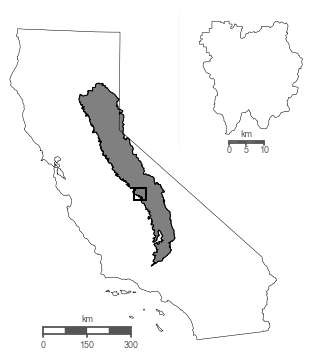

In [3]:
wrkDir = 'C:/Research/Dinkey_Creek/GIS_Data_And_Maps/'


shp = fiona.open(wrkDir + 'SierrasNad.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

shp = fiona.open(wrkDir + 'DinkeyCreek_LL.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords2 = list(chain(ll, ur))
w, h = coords2[2] - coords2[0], coords2[3] - coords2[1]



fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-124,llcrnrlat=32.4,urcrnrlon=-111.5,urcrnrlat=42.5,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = ax)

m.drawmapscale(
    coords[0] + .5, coords[1] - 2,
    coords[0], coords[1],
    300.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1)

    
m.readshapefile(wrkDir + 'SierrasNad', 'Sierra',
    color='black', zorder=5)
sierraPatches = []

for info, shape in zip(m.Sierra_info, m.Sierra):
    if info['SECTION_NA'] == 'Sierra Nevada':
        sierraPatches.append( PolygonM(np.array(shape), True) )
ax.add_collection(PatchCollection(sierraPatches, 
          facecolor= 'grey', edgecolor='k', linewidths=1., zorder=2))

m.readshapefile(wrkDir + 'CaliforniaBoundary', 'Cali',
    color='black', zorder = 8)


axins = zoomed_inset_axes(ax, 12, loc=1)
m2 = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = axins)
m2.fillcontinents(color='white')
m2.readshapefile(wrkDir + 'DinkeyCreek_LL', 'Elevation',
    color='black',ax = axins)

axins.spines['left'].set_visible(False)
axins.spines['bottom'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)


elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m2.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m2.Elevation_info[shape[0]].keys(),m2.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    axins.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1

m2.drawmapscale(
    coords2[0] + 0.15, coords2[1] - 0.02,
    coords2[0], coords2[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=2)

lbx2, lby2 = m(*m2(m2.xmin, m2.ymin, inverse= True))
ltx2, lty2 = m(*m2(m2.xmin, m2.ymax, inverse= True))
rtx2, rty2 = m(*m2(m2.xmax, m2.ymax, inverse= True))
rbx2, rby2 = m(*m2(m2.xmax, m2.ymin, inverse= True))

verts2 = [
    (lbx2, lby2), # left, bottom
    (ltx2, lty2), # left, top
    (rtx2, rty2), # right, top
    (rbx2, rby2), # right, bottom
    (lbx2, lby2), # ignored
    ]

codes2 = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts2, codes2)
patch = patches.PathPatch(path, facecolor = 'none', lw=2, zorder = 6)
ax.add_patch(patch)
plt.savefig('AreaMap.tif', dpi = 500)

### Three panel metadata figure
Look at what went into creating ecoregions, from elevation to soiltype, and display the ecoregions.

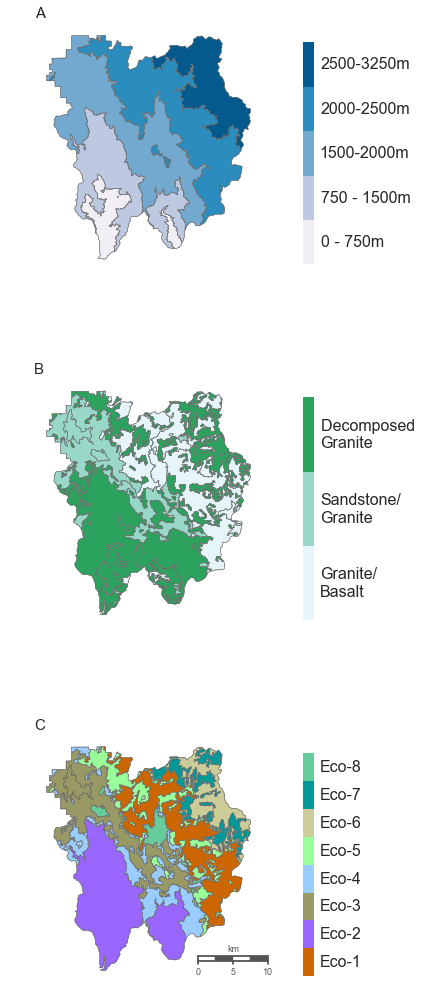

In [4]:
from matplotlib import colors

shp = fiona.open(wrkDir + 'DinkeyElevationShp.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig1 = plt.figure(figsize = (6,15))

ax = fig1.add_subplot(311, frameon = False)

Z = [[0,0],[0,0]]
levels = range(0,6)    #or whatever you need here
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
cmapELEV = colors.ListedColormap(elevFC)
CS3 = plt.contourf(Z, levels, cmap = cmapELEV)
plt.cla()                   #deletes the dummy plot
cb = plt.colorbar(CS3,ticks=[0.5,1.5,2.5,3.5,4.5], shrink=.65)
cb.ax.set_yticklabels(['0 - 750m', '750 - 1500m', '1500-2000m','2000-2500m','2500-3250m'], fontsize = 16)
cb.ax.artists.remove(cb.outline) 


m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyElevationShp', 'Elevation',
    color='grey',
    zorder=2)

# set up a map dataframe
elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Elevation_info[shape[0]].keys(),m.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1
ax.text(.1, 1, 'A', transform=ax.transAxes, fontsize=15)


ax = fig1.add_subplot(312, frameon = False)

Z = [[0,0],[0,0]]
levels = range(0,4)    
ParentGFC = ['#e5f5f9','#99d8c9','#2ca25f']
cmapPG = colors.ListedColormap(ParentGFC)
CS3 = plt.contourf(Z, levels, cmap = cmapPG)
plt.cla()                   #deletes the dummy plot
cb = plt.colorbar(CS3,ticks=[0.5,1.5,2.5], shrink=.65)
cb.ax.set_yticklabels(['Granite/\nBasalt', 'Sandstone/\nGranite', 'Decomposed \nGranite'], fontsize = 16)
cb.ax.artists.remove(cb.outline) 

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyGSSURGODissolveNAD83', 'PGroup',
    color='grey',
    zorder=2)

# set up a map dataframe
parentgroup = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.PGroup]})
for shape in enumerate(df_map['poly']):
    keys, values = m.PGroup_info[shape[0]].keys(),m.PGroup_info[shape[0]].values()
    parentgroup.append(values[3])
df_map['ParentGroup'] = parentgroup
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
idx = 0 # Colormap iterator
for feature in np.unique(df_map.ParentGroup):
    ax.add_collection(PatchCollection(df_map.patches[df_map.ParentGroup == feature], facecolor= ParentGFC[idx]))
    idx = idx + 1

shp = fiona.open(wrkDir + 'EcoregionsNAD83.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
ax.text(.1, 1, 'B', transform=ax.transAxes, fontsize=15)



ax = fig1.add_subplot(313, frameon = False)

Z = [[0,0],[0,0]]
levels = range(0,9)    
EcoregionFC =  ['#cc6600', '#9966ff','#999966',
                           '#99ccff', '#99ff99', '#cccc99', 
                           '#009999', '#66cc99']
cmapEco = colors.ListedColormap(EcoregionFC)

CS3 = plt.contourf(Z, levels, cmap = cmapEco)
plt.cla()                   #deletes the dummy plot
cb = plt.colorbar(CS3,ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], shrink=.65)
cb.ax.set_yticklabels(['Eco-1', 'Eco-2', 'Eco-3','Eco-4',
                       'Eco-5','Eco-6','Eco-7','Eco-8'], 
                      fontsize = 16)
cb.ax.artists.remove(cb.outline) 

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'EcoregionsNAD83', 'Ecoregion',
    color='grey',
    zorder=2)

# set up a map dataframe
ecoregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Ecoregion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Ecoregion_info[shape[0]].keys(),m.Ecoregion_info[shape[0]].values()
    ecoregion.append(values[5])
df_map['Ecoregion'] = ecoregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ecocolors = ['#cc6600', '#9966ff','#999966',
                           '#99ccff', '#99ff99', '#cccc99', 
                           '#009999', '#66cc99']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.Ecoregion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Ecoregion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

ax.text(.1, 1, 'C', transform=ax.transAxes, fontsize=15)
plt.tight_layout()
plt.savefig('ThreePanel_draft.tif', dpi = 400)
plt.show()


### Fire history and size distribution
One figure to sum up the data that went into generating our historic fire size and frequency parameterization

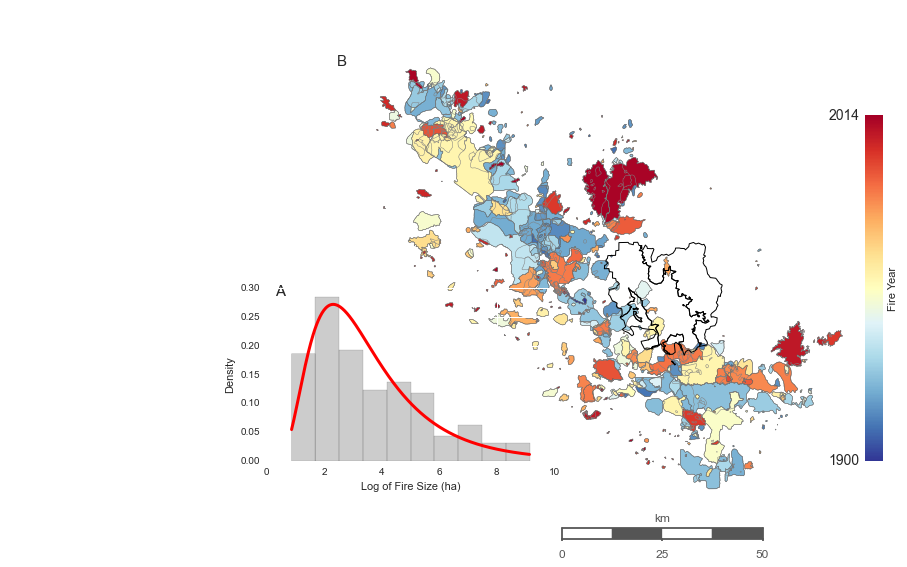

In [5]:
from scipy import stats

shp = fiona.open(wrkDir + 'DinkeyMetroFires.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig3, (ax) = plt.subplots(1,1, figsize =(16,16))

m = Basemap(llcrnrlon=-121,llcrnrlat=36.5,urcrnrlon=-118.5,urcrnrlat=37.70,
             resolution='i', projection='aea', lat_0 = 37.62, lon_0 = -119.51)
    
m.readshapefile(wrkDir + 'DinkeyMetroFires', 'FireRegion',
    color='grey',
    zorder=2)

m.readshapefile(wrkDir + 'DinkeyFireRegions_ll', 'FireRegionD',
    color='black', linewidth = 1,
    zorder=2)


# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[2])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

fireregion = map(int, fireregion)
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('RdYlBu_r'))
p.set_array(np.array(fireregion))
p.set_clim([np.ma.min(fireregion),np.ma.max(fireregion)])
ax.add_collection(p)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.8, coords[1] - 0.1,
    coords[0], coords[1],
    50., fontsize = 12,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

cbaxes = fig3.add_axes([0.87, 0.35, 0.015, 0.3]) 
cbar = plt.colorbar(p, cax = cbaxes, ticks = [1900,2014])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Fire Year')
#cbar = plt.colorbar(p, shrink = 0.3, ticks=[1900, 2014])
ax.text(.37, .89, 'B', transform=ax.transAxes, fontsize=15)

axsub = fig3.add_axes([0.35, 0.35, 0.25, 0.15], zorder = 0)

metadata = pd.read_csv(wrkDir + 'DinkeyMetroFires_metadata.txt')
# Data driven approach:
metadata['HECTARES'] = metadata.GIS_ACRES * 0.404686
firesizeMu = np.log(metadata.HECTARES).mean()
firesizeSd = np.log(metadata.HECTARES).std()
metadata = metadata[metadata.YEAR_ > 1983]
# Modeled approach:
# Limit fires to those > 1 ha
metadata.HECTARES[metadata.HECTARES < 1] = np.nan
firesize = np.log(metadata.HECTARES).dropna()
rvs = firesize # Generate some random variates as data
#n, bins, patches = plt.hist(rvs, bins=25, normed=True) # Plot histogram

shape, loc, scale = stats.lognorm.fit(rvs, floc=0) # Fit a curve to the variates
mu = np.log(scale) # Mean of log(X)
sigma = shape # Standard deviation of log(X)
M = np.exp(mu) # Geometric mean == median
s = np.exp(sigma) # Geometric standard deviation

# Plot figure of results
x = np.linspace(rvs.min(), rvs.max(), num=400)
g = sns.distplot(rvs, kde=False, ax = axsub, 
                 color = 'gray', norm_hist = True);
axsub.plot(x, stats.lognorm.pdf(x, shape, 
            loc=0, scale=scale), 'r', linewidth=3) # Plot fitted curve
axsub.set_xlabel('Log of Fire Size (ha)')
axsub.set_ylabel('Density')
sns.despine()
axsub.patch.set_facecolor('none')
ax.axis('off')
ax.text(.3, .46, 'A', transform=ax.transAxes, fontsize=15)

plt.savefig('FireSize_Dist.tif', dpi = 700)


### Fire region and fireweather distributions
Illustrate the fire regions and draw distributions for the inputs to the DFFS in landis, showing primarily the difference in fire weather between historic and severe.

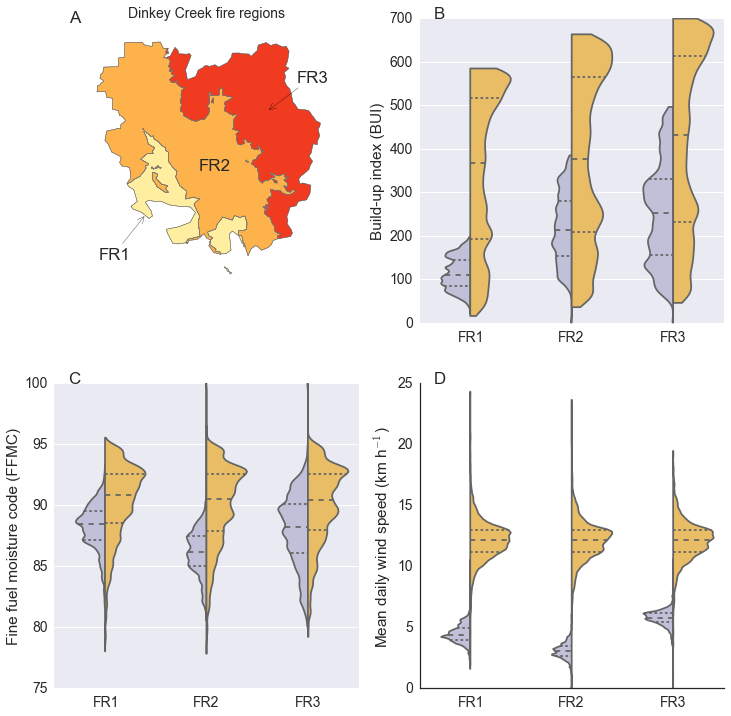

In [6]:
sns.set_context('notebook',font_scale=1.4)

shp = fiona.open(wrkDir + 'DinkeyFireRegions_ll.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig1 = plt.figure(figsize = (12,12))
ax = fig1.add_subplot(221, frameon = False)
m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyFireRegions_ll', 'FireRegion',
    color='grey',
    zorder=2)

# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[3])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ['#ffeda0', '#feb24c', '#f03b20']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.FireRegion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.FireRegion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey Creek fire regions', fontsize = 14)


ax.text(0.05, 1, 'A', transform=ax.transAxes, fontsize=17)
ax.annotate("FR1",
            xy=(0.3, 0.35), xycoords='axes fraction',
            xytext=(0.15, 0.2), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax.text(0.48, 0.5, 'FR2', transform=ax.transAxes, fontsize=17)
ax.annotate("FR3",
            xy=(0.7, 0.7), xycoords='axes fraction',
            xytext=(0.8, 0.8), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )


FW_His = pd.read_csv('Z:\DinkeyFW_Historic.csv')
FW_Sev = pd.read_csv('Z:\DinkeySevereFW.csv')

FW_His['FW_TYPE'] = 'Historic'
FW_Sev['FW_TYPE'] = 'Severe'
allFW = pd.concat([FW_His, FW_Sev])

ax = fig1.add_subplot(222)

FWSevColors = ["#bcbddc","#fec44f"]
FWSev = sns.color_palette(FWSevColors)

fwDistributions = sns.violinplot(x="Ecoregion", y="BUI", hue="FW_TYPE",
                     data=allFW, palette = FWSev,
                     split=True, scale = 'count', 
                     inner="quartile", cut = 0, bw = 0.1, ax = ax)
ax.set_ylabel('Build-up index (BUI)')
ax.set_xlabel('')

ax = gca()
ax.legend_.remove()
#ax.set_ylim([0,800])
sns.despine()
ax.text(0.05, 1, 'B', transform=ax.transAxes, fontsize=17)

ax = fig1.add_subplot(223)
fwDistributions = sns.violinplot(x="Ecoregion", y="FFMC", hue="FW_TYPE",
                     data=allFW, palette = FWSev,
                     split=True, scale = 'count', 
                     inner="quartile", cut = 0, bw = 0.1, ax = ax)
ax.set_ylabel('Fine fuel moisture code (FFMC)')
ax.set_xlabel('')

ax = gca()
ax.legend_.remove()
ax.text(0.05, 1, 'C', transform=ax.transAxes, fontsize=17)

sns.despine()
sns.set_style('white')

ax = fig1.add_subplot(224)
fwDistributions = sns.violinplot(x="Ecoregion", y="WSV", hue="FW_TYPE",
                     data=allFW, palette = FWSev,
                     split=True, scale = 'count', 
                     inner="quartile", cut = 0, bw = 0.1,
                                 ax = ax)
ax.set_ylabel('Mean daily wind speed (km h$^{-1}$)')
ax.set_xlabel('')
ax = gca()
ax.legend_.remove()
ax.text(0.05, 1, 'D', transform=ax.transAxes, fontsize=17)


sns.despine()
plt.savefig('FireRegionAndWeather.tif')

### Process the LANDIS output
and create data frames by treatment, for the sake of plotting down the road.

In [7]:
simNamesV2 = ['NoMgmtHistoricFireLowP','NoMgmtSevereFireLowP',
            'ThinHistoric_FV2', 'ThinSevere_FV2',
            'ThinRxHistoric_FV2','ThinRxSevere_FV2']

def centOutputGen(dataDir, simname):
    wkDir_reps =  dataDir + simname + '/'
    centFileName = 'Century-succession-log.csv'
    centFileNameM = 'Century-succession-monthly-log.csv'
    sppBioName = 'spp-biomass-log.csv'

    repnames = next(os.walk(wkDir_reps))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        repnum = rep.split('replicate')[1]
        wkDir_data = wkDir_reps + 'replicate' + repnum + '/'
        cent = pd.read_csv(wkDir_data + centFileName)
        cent['rep'] = int(repnum)
        centM = pd.read_csv(wkDir_data + centFileNameM)
        centM['rep'] = int(repnum)
        sppBio = pd.read_csv(wkDir_data + sppBioName)
        sppBio['rep'] = int(repnum)

        if idx == 0:
            centTot = cent
            centTotM = centM
            sppBioTot = sppBio

        else:
            centTot = pd.concat((centTot, cent))
            centTotM = pd.concat((centTotM, centM))
            sppBioTot = pd.concat((sppBioTot, sppBio))

        idx = idx + 1
    return centTot, centTotM, sppBioTot


def genCentWeightedMeansDF(aggregatedAnnualCentFile, simName):
    simCentDF = aggregatedAnnualCentFile
    # ------- Create new vars in Cent file and handle unit conversion ------- #
    simCentDF['TEC'] = (simCentDF['SOMTC'] + simCentDF['AGB']* 0.5 ) * 0.01 # Add total ecosystem carbon, Mg/ha
    simCentDF['AGBc'] = simCentDF['AGB']* 0.5 * 0.01 # Convert AGB from g /m^2 biomass to Mg/ha C
    simCentDF['NEEC'] = simCentDF['NEEC'] * -1 * 0.01 # Convert NEE sign convention 
    simCentDF['NECB'] = simCentDF['NEEC'] - (simCentDF['FireCEfflux'] * 0.01)
    activeArea = simCentDF.NumSites.unique().sum() # Calculate total sites in the simulation

    # ------- Generate mean and std of weighted ecoregion data ------- #
    simCentDF['TECw'] = simCentDF.TEC * (simCentDF.NumSites / activeArea)
    simCentDF['AGBw'] = simCentDF.AGBc * (simCentDF.NumSites / activeArea)
    simCentDF['NEECw'] = simCentDF.NEEC * (simCentDF.NumSites / activeArea)
    
    # Convert the fire efflux from g/m2 to Mg/ha (already in units of C), and 
    # produce the ecoregion weighted per hectare value
    simCentDF['FireCEffluxw'] = simCentDF.FireCEfflux * 0.01 * (simCentDF.NumSites / activeArea)
    simCentDF['NECBw'] = simCentDF['NEECw'] - simCentDF['FireCEffluxw']
    
    naiveMean = simCentDF.groupby(['EcoregionName','Time']).mean()
    naiveStd = simCentDF.groupby(['EcoregionName','Time']).std()
    
    # Generate a dataframe for that we can leverage when we want to ask questions
    # about the cumulative nature of some century variable, by replicate.
    naiveSum= simCentDF.groupby(['rep']).sum()

    naiveMean['NEECw_std'] = naiveStd.NEEC * (naiveMean.NumSites / activeArea) # 
    naiveMean['AGBw_std'] = naiveStd.AGBc * (naiveMean.NumSites / activeArea)
    naiveMean['TECw_std'] = naiveStd.TEC * (naiveMean.NumSites / activeArea)
    naiveMean['FireCEffluxw_std'] = naiveStd.FireCEfflux * (naiveMean.NumSites / activeArea)
    naiveMean['NECBw_std'] = naiveStd.NECBw * (naiveMean.NumSites / activeArea)
    resetMean = naiveMean.reset_index()
    resetSum = naiveSum.reset_index()
    
    # ------- Generate region-wide weighted mean of all ecoregions ------ #
    weightedMean = resetMean.groupby('Time').sum()  
    index = pd.date_range('2000-1-1', periods=len(weightedMean), freq='1A')
    weightedMean.index = index
    weightedMean[weightedMean.NEECw == 0] = np.nan
    weightedMean['Sim'] = simName
    resetSum['Sim'] = simName
    simCentDF['Sim'] = simName

    return weightedMean, simCentDF, resetSum

def plotSimulationCarbon(weightedMeansDF):
    weightedMean = weightedMeansDF
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
    plt.subplots_adjust(wspace = 0.3)
    simidx = 0
    simColors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c', 'black']
    for sim in np.unique(weightedMean.Sim):
        print sim
        simMean = weightedMean[weightedMean.Sim == sim]
        simMean.AGBw.plot(ax = ax1, color = simColors[simidx])
        simMean.TECw.plot(ax = ax2, color = simColors[simidx])
        simMean.NEECw.plot(ax = ax3, color = simColors[simidx])
        simMean.FireCEffluxw.cumsum().plot(ax = ax4, color = simColors[simidx])
        simMean.NECBwHA = simMean.NECBw * 0.01 # Mg/ha for cumulative curves
        simMean.NECBwHA_stdHA = simMean.NECBw_std * 0.01 # Mg/ha for cumulative curves
        simMean.NECBwHA.plot(ax = ax6, color = simColors[simidx])
        

        ax1.fill_between(simMean.index, 
                         simMean.AGBw+simMean.AGBw_std, 
                         simMean.AGBw-simMean.AGBw_std, 
                         alpha = 0.2, color = simColors[simidx])

        ax2.fill_between(simMean.index, 
                         simMean.TECw+simMean.TECw_std, 
                         simMean.TECw-simMean.TECw_std, 
                         alpha = 0.2, color = simColors[simidx])
        
        ax3.fill_between(simMean.index, 
                         simMean.NEECw+simMean.NEECw_std, 
                         simMean.NEECw-simMean.NEECw_std, 
                         alpha = 0.2, color = simColors[simidx])
        
        #Replaced the cumulatiev curves with boxplots of cumulative C emissions from fire
        ax4.fill_between(simMean.index, 
                         simMean.FireCEffluxw.cumsum()+simMean.FireCEffluxw_std, 0,
                         alpha = 0.2, color = simColors[simidx])
        
        ax6.fill_between(simMean.index, 
                         simMean.NECBwHA+simMean.NECBwHA_stdHA, 
                         simMean.NECBwHA-simMean.NECBwHA_stdHA, 
                         alpha = 0.2, color = simColors[simidx])
        
        simidx = simidx + 1

    # ------ Aesthetics ------ #
    ax1.set_ylabel('AGB (MgC ha $^{-1}$)')
    ax2.set_ylabel('TEC (Mg ha $^{-1}$)')
    ax3.set_ylabel('NEE (gC m$^{-2}$)')
    ax4.set_ylabel('Cumulative Fire Efflux gC m$^{-2}$)')
    ax5.set_ylabel('AGB (MgC ha $^{-1}$)')
    ax6.set_ylabel('Cumulative NECB MgC ha$^{-1}$)')
    
    ax2.set_xlabel('Simulation Year')
    ax5.set_xlabel('Model Simulation')
    
    lastTen = weightedMean[weightedMean.index.year >= 2090]
    #g = sns.boxplot(x="Sim", y=weightedMean.FireCEffluxw,
    #              data=weightedMean, ax = ax4, palette=simColors)
    ax4.set_xticklabels(lastTen.Sim.unique(),rotation = 45)
    #ax4.set_ylim([0,1000])

    g = sns.boxplot(x="Sim", y="AGBw",
                  data=lastTen, ax = ax5, palette=simColors)
    ax5.set_xticklabels(lastTen.Sim.unique(),rotation = 45)
    
    sns.despine()
    sns.set_style('white')
    sns.set_context('notebook', font_scale=1.5)

    ax1.legend(np.unique(weightedMean.Sim), loc = 'lower right')
    
prodDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'

simCentH, simCent_mH, sppbioHis = centOutputGen(prodDir, simNamesV2[0])
simCentS, simCent_mS, sppbioSev = centOutputGen(prodDir, simNamesV2[1])
simCentHT, simCent_mHT, sppbioHisT = centOutputGen(prodDir, simNamesV2[2])
simCentST, simCent_mST, sppbioSevT = centOutputGen(prodDir, simNamesV2[3])
simCentHTRx, simCent_mHTRx, sppbioHisTRx = centOutputGen(prodDir, simNamesV2[4])
simCentSTRx, simCent_mSTRx, sppbioSevTRx = centOutputGen(prodDir, simNamesV2[5])


weightedHWF, simCentCHWF, summedHWF = genCentWeightedMeansDF(simCentH, 'No Mgmt HWF')
weightedSWF, simCentCSWF, summedSWF = genCentWeightedMeansDF(simCentS, 'No Mgmt SWF')
weightedHWFT, simCentCHWFT, summedHWFT = genCentWeightedMeansDF(simCentHT, 'Thinning HWF')
weightedSWFT, simCentCSWFT, summedSWFT = genCentWeightedMeansDF(simCentST, 'Thinning SWF')
weightedHWFTRx, simCentCHWFTRx, summedHWFTRx = genCentWeightedMeansDF(simCentHTRx, 'ThinningRx HWF')
weightedSWFTRx, simCentCSWFTRx, summedSWFTRx = genCentWeightedMeansDF(simCentSTRx, 'ThinningRx SWF')

totSims = pd.concat([weightedHWF, weightedSWF, weightedHWFT, weightedSWFT,weightedHWFTRx,weightedSWFTRx])
totSimsNW = pd.concat([simCentCHWF, simCentCSWF, simCentCHWFT, simCentCSWFT,simCentCHWFTRx,simCentCSWFTRx])
totSums = pd.concat([summedHWF, summedSWF, summedHWFT, summedSWFT,summedHWFTRx,summedSWFTRx])

Historic = [np.unique(totSims.Sim)[0],np.unique(totSims.Sim)[2],np.unique(totSims.Sim)[4]]
Severe = [np.unique(totSims.Sim)[1],np.unique(totSims.Sim)[3],np.unique(totSims.Sim)[5]]
simsSevere = totSims[(totSims.Sim == Severe[0]) | (totSims.Sim == Severe[1]) | (totSims.Sim == Severe[2])]
simsHistoric = totSims[(totSims.Sim == Historic[0]) | (totSims.Sim == Historic[1]) | (totSims.Sim == Historic[2])]

#### We need a figure (or just the data) to show our AGB parameterization relative to FIA inputs
Since all IC and Century climate data are the same, all spin-up biomass maps look identical. I'll just grab one and use it to generate our biomass distribution. Then we have to read in the FIA biomass for the FIA plots within the Dinkey Creek area -- here, I calculated AGB using Jenkins allometries.

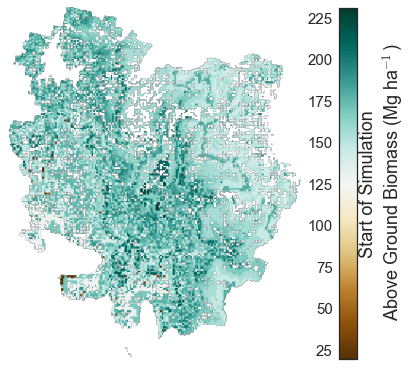

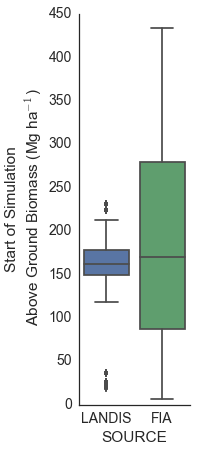

In [8]:
# Read in the raster
biomap = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP/replicate1/bioMAP/bio-TotalBiomass-0.img'
src_ds = gdal.Open( biomap )
bioarray = src_ds.ReadAsArray()
bioarray = bioarray.astype('float')
bioarray[bioarray == 0] = np.nan
bioarray = bioarray * 0.01
masked_bio = np.ma.array (bioarray, mask=(np.isnan(bioarray)))  

# Create the figure and show the image
f, (ax) = plt.subplots(1,1, figsize =(7,7))
axmap = ax.imshow(bioarray, cmap = 'BrBG')

# Color bar
cbar = f.colorbar(axmap, shrink=0.9, pad = 0.1)
cbar.set_label('Start of Simulation \n Above Ground Biomass (Mg ha$^{-1}$)', fontsize = 18)
cbar.ax.tick_params(labelsize=15) 
sns.despine(left=True, bottom=True)
ax.set_yticklabels('')
ax.set_xticklabels('')

plt.savefig('BiomassMap.tif', dpi = 300)
# Axis label formatting, and seaborn despining
ax.set_yticklabels('')
ax.set_xticklabels('')
sns.despine(left=True, bottom=True)
sns.set_style('white')

# Create a dataframe from the raster, and join it to previously worked up FIA data
initBio = pd.DataFrame(dict(Biomass = bioarray.ravel(), SOURCE = 'LANDIS'))
fiaBio = pd.read_csv('Z:/Dan K/DinkeyCreek/LANDIS_RUNS/JenkinsDinkeyBiomass.csv')
fiaBio.Biomass = fiaBio.Biomass * 0.01
validateBio = pd.concat([initBio, fiaBio])

# Boxplot the FIA and LANDIS initial biomass data
f, (ax) = plt.subplots(1,1, figsize =(2,7))
sns.boxplot(y = 'Biomass', x = 'SOURCE', data = validateBio.dropna())
ax.set_ylabel('Start of Simulation \n Above Ground Biomass (Mg ha$^{-1}$)')
sns.despine()

### Above ground carbon and total ecosystem carbon
Heres half the story -- C trends by treatment. 

No Mgmt HWF
Thinning HWF
ThinningRx HWF
No Mgmt HWF
Thinning HWF
ThinningRx HWF
No Mgmt SWF
Thinning SWF
ThinningRx SWF
No Mgmt SWF
Thinning SWF
ThinningRx SWF
No Mgmt SWF
Thinning SWF
ThinningRx SWF
No Mgmt HWF
Thinning HWF
ThinningRx HWF


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


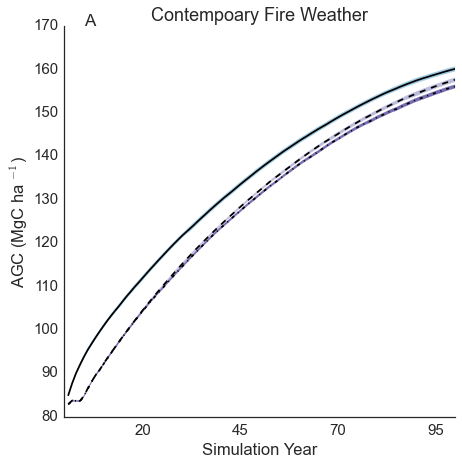

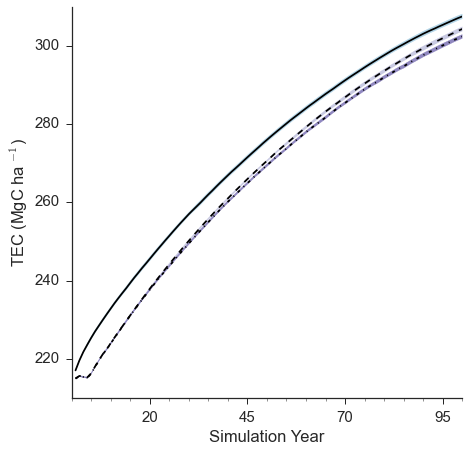

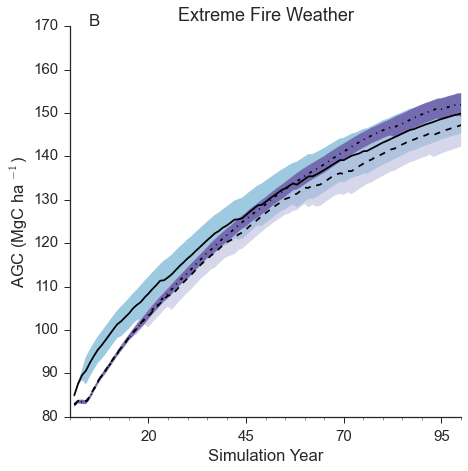

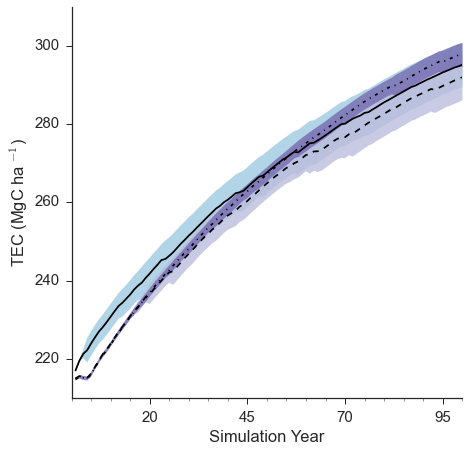

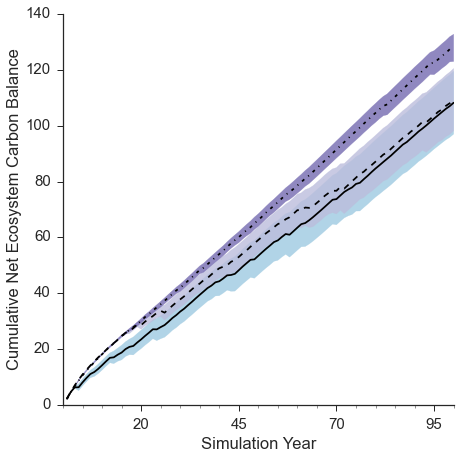

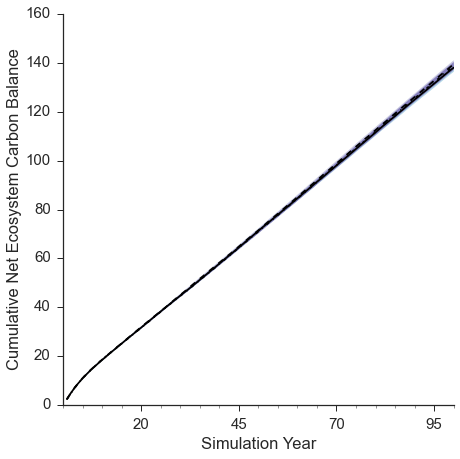

In [9]:
sns.set_context('notebook', font_scale=1.5)
colorscheme = ['#9ecae1','#bcbddc','#756bb1']
### HISTORIC FIRE WEATHER AGB -------------------------------

f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simStyles = ['-','--','-.']
for sim in Historic:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.AGBw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                     simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                     simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                     color = colorscheme[simidx])

    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])

ax.set_title('Contempoary Fire Weather')
ax.set_xlabel('Simulation Year')
ax.set_ylabel('AGC (MgC ha $^{-1}$)')
ax.text(0.05, 1, 'A', transform=ax.transAxes, fontsize=17)
ax.set_ylim([80, 170])

sns.despine()
sns.set_style('ticks')
plt.savefig('Historic_AGC_insetBox.tif', dpi = 300)


### HISTORIC FIRE WEATHER TEC -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simStyles = ['-','--','-.']
for sim in Historic:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.TECw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.TECw+3*simMean.TECw_std/np.sqrt(50), 
                 simMean.TECw-3*simMean.TECw_std/np.sqrt(50), 
                 alpha = 0.8, color = colorscheme[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])



ax.set_ylim([210, 310])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('TEC (MgC ha $^{-1}$)')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Historic_TEC_insetBox.tif')


### SEVERE FIRE WEATHER AGB -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simStyles = ['-','--','-.']
for sim in Severe:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.AGBw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    if simidx == 0:
        ax.fill_between(simMean.index, 
                     simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                     simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                     color = colorscheme[simidx])
    if simidx == 2:
        ax.fill_between(simMean.index, 
                     simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                     simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                     color = colorscheme[simidx])

    else:
        ax.fill_between(simMean.index, 
                     simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                     simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                     alpha = 0.6, color = colorscheme[simidx])

    simidx = simidx + 1 
    ax.set_title('Extreme Fire Weather')
    ax.set_xticklabels([20,45,70,95])



ax.set_xlabel('Simulation Year')
ax.set_ylabel('AGC (MgC ha $^{-1}$)')
ax.text(0.05, 1, 'B', transform=ax.transAxes, fontsize=17)
ax.set_ylim([80,170])
sns.despine()
sns.set_style('ticks')
plt.savefig('Severe_AGC_insetBox.tif', dpi = 300)


### SEVERE FIRE WEATHER TEC -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simStyles = ['-','--','-.']
for sim in Severe:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.TECw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.TECw+3*simMean.TECw_std/np.sqrt(50), 
                 simMean.TECw-3*simMean.TECw_std/np.sqrt(50), 
                 alpha = 0.8, color = colorscheme[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('TEC (MgC ha $^{-1}$)')

sns.despine()
sns.set_style('ticks')
plt.savefig('Severe_TEC_insetBox.tif')


### SEVERE FIRE WEATHER NECB -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simStyles = ['-','--','-.']
for sim in Severe:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.NECBw.cumsum().plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.NECBw.cumsum()+3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 simMean.NECBw.cumsum()-3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 alpha = 0.8, color = colorscheme[simidx])
    simidx = simidx + 1
    ax.set_xticklabels([20,45,70,95])


ax.set_xlabel('Simulation Year')
ax.set_ylabel('Cumulative Net Ecosystem Carbon Balance')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Severe_NECB.tif')



f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simStyles = ['-','--','-.']
for sim in Historic:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.NECBw.cumsum().plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.NECBw.cumsum()+3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 simMean.NECBw.cumsum()-3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 alpha = 0.8, color = colorscheme[simidx])
    simidx = simidx + 1
    ax.set_xticklabels([20,45,70,95])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('Cumulative Net Ecosystem Carbon Balance')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Historic_NECB.tif')


### Adding significance tests for year 100 C stocks
While the last decade of the simulation shows some differences in C stocks with treatment and fire weather, we need to test the actual end of simulation for differences. We need to pull out the end of simulation C values, then run a test on them. This is oddly a pain, since I never preserved any century output by replicate, I just calculated means and variances to populate the output dataframe. I went through the genWeightedCent function to append the simulation name to the fully aggregated century dataframe, and added a bit of code to output a version of the data that had not been aggregated by replicate. Takes a little bit of tape for the time being but heres the solution

In [10]:
import numpy as np
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings


def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """
    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test
    Arguments:
    ---------------
    groups: sequence
        arrays corresponding to k mutually independent samples from
        continuous populations
    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.
    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)
    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)
    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic
    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal
    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison
    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.
    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha
    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.
    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])
    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)
    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')

    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=np.float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()

    # the Kruskal-Wallis H-statistic
    H = (12. / (N * (N + 1.))) * ((R ** 2.) / n).sum() - 3 * (N + 1)

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.chisqprob(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------

    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=np.float)
    p_uncorrected = np.empty(ncomp, dtype=np.float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):

        # standardized score
        Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
               np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        Z_pairs[pp] = Zij

    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method
    )

    return H, p_omnibus, Z_pairs, p_corrected, reject

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


     Multiple Comparison of Means - Tukey HSD,FWER=0.01    
   group1        group2     meandiff  lower   upper  reject
-----------------------------------------------------------
No Mgmt HWF   Thinning HWF   -2.613  -3.2304 -1.9956  True 
No Mgmt HWF  ThinningRx HWF -4.1401  -4.7575 -3.5227  True 
Thinning HWF ThinningRx HWF -1.5271  -2.1445 -0.9097  True 
-----------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD,FWER=0.01    
   group1        group2     meandiff  lower   upper  reject
-----------------------------------------------------------
No Mgmt SWF   Thinning SWF  -2.8038  -8.3729  2.7653 False 
No Mgmt SWF  ThinningRx SWF  2.2331   -3.336  7.8021 False 
Thinning SWF ThinningRx SWF  5.0369  -0.5322 10.6059 False 
-----------------------------------------------------------


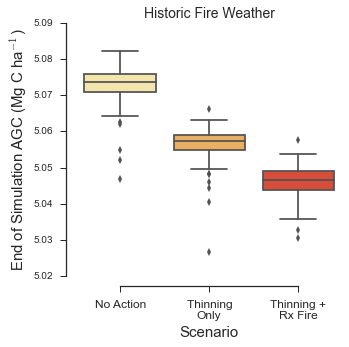

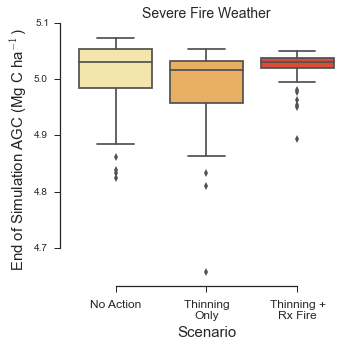

In [11]:
# Grab the dataframe without any means or sums by rep. Note, it also 
# doesn't have any sums over ecoregions, but it does
# have the apropriate columns to do so (the weighted columns... )
# We need to take a sum by ecoregion, but preserve simulation name, time, and rep
centReps = totSimsNW.groupby(['Time','Sim','rep']).sum().reset_index()

# Gut check, this looks similar to the output above -- good thing.
# Now we need to extract the year 100 values for our AGBw column. 
# Note here we don't have a timestamp index either. No bother, we will
# use the 'Time' column rather than index.year.
centReps100 = centReps[centReps.Time > 94]

# 8/23/16 -- pointed out that not taking the mean of the last 5 years by rep was pretty bogus .. now
# our statistical power is more a function of replication (50 reps per sim).
centReps100 = centReps100.groupby(['Sim','rep']).mean().reset_index()

# Separate this dataframe into historic and severe simulations
HWF = centReps100[(centReps100.Sim == 'No Mgmt HWF') | \
                  (centReps100.Sim == 'Thinning HWF') | \
                  (centReps100.Sim == 'ThinningRx HWF')]

SWF = centReps100[(centReps100.Sim == 'No Mgmt SWF') | \
                  (centReps100.Sim == 'Thinning SWF') | \
                  (centReps100.Sim == 'ThinningRx SWF')]

HWF['LTAGB'] = np.log(HWF.AGBw)
SWF['LTAGB'] = np.log(SWF.AGBw)

# Make a couple quick plots to visualize the differences
f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'LTAGB', data = HWF, 
                  palette=EcoregionFC)

sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('End of Simulation AGC (Mg C ha$^{-1}$)', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('AGB_year100_Historic_bar.tif')

f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'LTAGB', data = SWF, 
                  palette=EcoregionFC)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('End of Simulation AGC (Mg C ha$^{-1}$)', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('AGB_last_Severe_bar.tif')

print pairwise_tukeyhsd(HWF.dropna()['AGBw'], HWF.dropna()['Sim'], alpha=0.005)
print pairwise_tukeyhsd(SWF.dropna()['AGBw'], SWF.dropna()['Sim'], alpha=0.005)

# The result shows in the historic fire weather condition, all treatments are significantly different
# from one another, p < 0.05. In the severe fire weather condition, the only significant difference is
# the thin only from the thin and burn (p < 0.05).

#### Just for the sake of printing out these data
since I reference their values in the manuscript, we might as well have them on hand here too. These are the mean AGC values per fire weather and treatment. HWF is Historic fire, SWF is Severe fire. These data are responsible for generating the boxplots above.

In [12]:
HWF.groupby('Sim').describe().AGBw

Sim                  
No Mgmt HWF     count     50.000000
                mean     159.533452
                std        1.099466
                min      155.536001
                25%      159.302382
                50%      159.769809
                75%      160.085861
                max      161.102121
Thinning HWF    count     50.000000
                mean     156.920478
                std        0.984423
                min      152.426577
                25%      156.798462
                50%      157.165887
                75%      157.419213
                max      158.546697
ThinningRx HWF  count     50.000000
                mean     155.393336
                std        0.800103
                min      153.008593
                25%      155.048770
                50%      155.503824
                75%      155.887832
                max      157.225579
Name: AGBw, dtype: float64

In [13]:
SWF.groupby('Sim').describe().AGBw

Sim                  
No Mgmt SWF     count     50.000000
                mean     149.264912
                std        9.994645
                min      124.576196
                25%      145.992318
                50%      152.911470
                75%      156.639356
                max      159.616563
Thinning SWF    count     50.000000
                mean     146.461105
                std       10.486269
                min      105.450699
                25%      142.268324
                50%      150.728581
                75%      153.183859
                max      156.560124
ThinningRx SWF  count     50.000000
                mean     151.497990
                std        4.408863
                min      133.474567
                25%      151.221383
                50%      152.981356
                75%      154.079777
                max      155.989095
Name: AGBw, dtype: float64

#### I wasn't thinking about the assumption that variances between groups need to be the same for ANOVA, and consequently Tukey's HSD post hoc.
Which sucks, since now I've got to use some sort of non-parametric test to show the obvious. First a quick bartlett's to assure that yes, they are different.

In [14]:
HWFNA = HWF[HWF.Sim == 'No Mgmt HWF']
HWFTO = HWF[HWF.Sim == 'Thinning HWF']
HWFTB = HWF[HWF.Sim == 'ThinningRx HWF']

AH = HWFNA.LTAGB.ravel()
BH = HWFTO.LTAGB.ravel()
CH = HWFTB.LTAGB.ravel()

SWFNA = SWF[SWF.Sim == 'No Mgmt SWF']
SWFTO = SWF[SWF.Sim == 'Thinning SWF']
SWFTB = SWF[SWF.Sim == 'ThinningRx SWF']

AS = SWFNA.LTAGB.ravel()
BS = SWFTO.LTAGB.ravel()
CS = SWFTB.LTAGB.ravel()
inputs = [BH,CH]
print bartlett(*inputs)

inputs = [BS,CS]
print bartlett(*inputs)

BartlettResult(statistic=1.9828723633003522, pvalue=0.1590881360446188)
BartlettResult(statistic=37.991605643110397, pvalue=7.1049663598076611e-10)


#### Neat result -- heteroscedastic for severe fire weather only
This means we need another test for the severe fire scenario -- Kruskal Wallis should do the trick, but its foreign to me. We can stick with a classic ANOVA and Tukey's HSD for the historic runs.

In [15]:
mod = MultiComparison(HWF['AGBw'], HWF['Sim'])
print mod.kruskal()

mod = MultiComparison(SWF['AGBw'], SWF['Sim'])
print mod.kruskal()

MultiComparison.kruskal
0 1 48.66 9.21594948988 5.27997685463 True
1.29200206254e-07
1.29200206254e-07
MultiComparison.kruskal
0 1 21.94 9.21594948988 2.38065540877 False
0.0172818696614
0.0172818696614


#### Need to apply some sort of posthoc on this now, Dunn's seems to be commonly used
and I can find an implementation in python here:
    https://gist.github.com/alimuldal/fbb19b73fa25423f02e8
However, I'm not looking to do this all the hard way ... it would just be nice to keep the entire analysis in Python if possible. 

In [16]:
# Historic AGC
kw_dunn([AH,BH,CH], to_compare=[(0,1),(0,2),(1,2)], alpha = 0.005)

(111.46788874172194,
 6.238145570447374e-25,
 array([  5.60013671,  10.55118235,   4.95104565]),
 array([  6.42548489e-08,   1.50485512e-25,   2.21447359e-06]),
 array([ True,  True,  True], dtype=bool))

In [17]:
# Severe AGC
kw_dunn([AS,BS,CS], to_compare=[(0,1),(0,2),(1,2)], alpha = 0.005)

(7.8542338312526354,
 0.019700388637787409,
 array([ 2.52501026,  0.20945846,  2.3155518 ]),
 array([ 0.03470847,  1.        ,  0.06174826]),
 array([ True, False, False], dtype=bool))

### Code to import and stack rasters to create maps of ... stuff


In [251]:
def severityStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'fire/'
            sevmap = 'severity-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)
            
    return rasterlist

def getRepList(rasterLoc):
    repnames = next(os.walk(rasterLoc))[1]
    return num_replicates, repnames

def stackSevByRep(rasterLoc, runLength, rep):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    repnum = rep.split('replicate')[1]
    for time in timesteps:  
        wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'fire/'
        sevmap = 'severity-' + str(int(time)) + '.img'
        src_ds = gdal.Open( wkDir_data + sevmap ) 
        sevarray = src_ds.ReadAsArray()
        sevarray = sevarray.astype('float')
        rasterlist.append(sevarray)
            
    return rasterlist

def NEEStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/century/'
            sevmap = 'nee-' + str(int(time)) + '.gis'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)
            
    return rasterlist

def THINStack(rasterLoc, runLength):
    rasterlist = []
    thinlist = []
    rxfirelist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/ThinMAP/'
            thinmap = 'biomass-removed-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + thinmap ) 
            thinarray = src_ds.ReadAsArray()
            thinarray = thinarray.astype('float')
            rasterlist.append(thinarray)
            if time < 10:
                thinlist.append(thinarray)
            else:
                rxfirelist.append(thinarray)
            
    return rasterlist, thinlist, rxfirelist

def severityGen(rasterList):
    rasterStack = np.dstack(rasterList)  
    rasterAdj = rasterStack - 2
    rasterAdj[rasterAdj < 0] = np.nan
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)
    return meanSev, varSev

def NEEGen(rasterList):
    rasterStack = np.dstack(rasterList)
    rasterStack[rasterStack == 0] = np.nan
    rasterAdj = rasterStack - 1000
    cumNEE = np.nansum(rasterAdj, axis = 2)
    varNEE = np.nanvar(rasterAdj, axis = 2)
    return cumNEE, varNEE

def THINGen(rasterList):
    rasterStack = np.dstack(rasterList)
    countTHIN = np.count_nonzero(rasterStack, axis = 2)
    rasterStack[rasterStack == 0] = np.nan
    cumTHIN = np.nansum(rasterStack, axis = 2)
    varTHIN = np.nanvar(rasterStack, axis = 2)
    return countTHIN, cumTHIN, varTHIN

def fireFreqGen(rasterList):
    rasterStack = np.dstack(rasterList)
    return rasterStack

# Stacked bar chart code grabbed then modified from the web
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=1.2,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, edgecolor = 'k', color = 'white', hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5], title = 'Fire Severity')
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1], title = 'Fire Weather') 
    axe.add_artist(l1)
    return axe

#### If we want to create a stacked bar chart of fire size by severity class, fire weather, and sim
Its actually a pretty large hassle. I modified some code I found for a slick stacked bar chart online and it seems to work pretty well, albeit a bit constricting in terms of how we can modify the plot attributes. Works for now. This will make a single cumulative bar chart for each sim across all reps (so total area burned by severity across 50 reps of 100 years).

In [65]:
dataDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'

idx = 0
for simName in [simNamesV2[0], simNamesV2[1], simNamesV2[2],
            simNamesV2[3], simNamesV2[4], simNamesV2[5]]:
    sevrasters = severityStack(dataDir + simName, 100)
    numIters = np.arange(0,5000)
    sevArray = []
    for iteration in numIters:
        sevArray.append(sevrasters[iteration].ravel())
    combinedArray = numpy.concatenate( sevArray, axis=0 )
    combinedArray = combinedArray - 2
    sev1 = combinedArray[combinedArray == 1].size
    sev2 = combinedArray[combinedArray == 2].size
    sev3 = combinedArray[combinedArray == 3].size
    sev4 = combinedArray[combinedArray == 4].size
    sev5 = combinedArray[combinedArray == 5].size
    if idx == 0:
        simSev = pd.DataFrame(dict(sim = simName, 
                            SEV1 = sev1, SEV2 = sev2, 
                            SEV3 = sev3, SEV4 = sev4, 
                            SEV5 = sev5), index = [idx])
    else:
        tempSev = pd.DataFrame(dict(sim = simName, 
                            SEV1 = sev1, SEV2 = sev2, 
                            SEV3 = sev3, SEV4 = sev4, 
                            SEV5 = sev5), index = [idx])
        simSev = pd.concat([simSev, tempSev])
    idx +=1


#### This creates a dataframe structure that contains the total hectates by sev class

In [79]:
simSev

SEV1    SEV2    SEV3    SEV4  SEV5                     sim  \
0  1006659   32354    4733      80     2  NoMgmtHistoricFireLowP   
1   278148  309793  367873  130609  7459    NoMgmtSevereFireLowP   
2   916193   19566    2025      40     8        ThinHistoric_FV2   
3   312134  287629  353375  149331  9880          ThinSevere_FV2   
4   926129   25104    4021      66     5      ThinRxHistoric_FV2   
5   531865  188978  154981   46571  2610        ThinRxSevere_FV2   

          Trtmnt  
0  No Management  
1             NA  
2             NA  
3             NA  
4             NA  
5             NA

In [225]:
warnings.filterwarnings("ignore")
simSev['Trtmnt'] = 'NA'
simSev['Trtmnt'][0] = 'No Management'
simSev['Trtmnt'][1] = 'No Management'
simSev['Trtmnt'][2] = 'Thinning Only'
simSev['Trtmnt'][3] = 'Thinning Only'
simSev['Trtmnt'][4] = 'Thinning and Maintenance\n Burning'
simSev['Trtmnt'][5] = 'Thinning and Maintenance\n Burning'

simSev['FWSev'] = 'NA'
simSev['FWSev'][0] = 'Contemporary'
simSev['FWSev'][1] = 'Severe'
simSev['FWSev'][2] = 'Contemporary'
simSev['FWSev'][3] = 'Severe'
simSev['FWSev'][4] = 'Contemporary'
simSev['FWSev'][5] = 'Severe'

firesSev_m = pd.melt(simSev, id_vars=['sim','Trtmnt','FWSev'])
warnings.filterwarnings("default")

#### With some tape we can get at the average size by rep
Its a pretty ghetto way of creating the plot but it does allow a considerable mor amount of control in the long run compares to a seaborn or pandas plot. It just feels like a shame to strip the dataframe of all of its inherent info prior to plotting.

In [308]:
df1 = simSev[simSev.FWSev == 'Contemporary']
df2 = simSev[simSev.FWSev == 'Severe']

del df1['sim']
del df1['Trtmnt']
del df1['FWSev']

del df2['sim']
del df2['Trtmnt']
del df2['FWSev']
df1 = df1 / (1000 * 50)
df2 = df2 / (1000 * 50)

df1.columns = ['1','2','3','4','5']
df2.columns = ['1','2','3','4','5']
sns.set_context('notebook', font_scale=1.5)
gg= plot_clustered_stacked([df1, df2],["Contemporary", "Extreme"], 
                           color = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000'],
                            H="//")
sns.despine()
gg.set_xticklabels(['No-management','Thin-only', 
                    'Thin and \nmaintenance burning'], rotation = 0)
gg.set_ylabel('Mean burned area\n (thousands of ha)')
gg.set_title('')
plt.savefig('StackedSevs.tif',bbox_inches='tight',dpi = 150)

AttributeError: 'DataFrame' object has no attribute 'FWSev'

#### Now if we wanted to create the same plot, with error bars
the trick would be to actually take the mean by replicate. Preserving replicate number through the raster stacking isn't something I usually need to do, and is sort of a hassle. I created two new functions to handle this action, and they operate pretty simply. Basically we determine the number of replicates for a given simulation (to allow for prototyping in the future before runs are complete), and then we operate over the stack and store the resulting info in a dataframe, with rep as another column.

In [252]:
idx = 0

for simName in [simNamesV2[0], simNamesV2[1], simNamesV2[2],
            simNamesV2[3], simNamesV2[4], simNamesV2[5]]:
    numReps, repNames = getRepList(dataDir + simName)
    for rep in repNames:
        sevArray = []
        sevrasters = stackSevByRep(dataDir + simName, 100, rep)

        combinedArray = numpy.concatenate( sevrasters, axis=0 )
        combinedArray = combinedArray - 2
        sev1 = combinedArray[combinedArray == 1].size
        sev2 = combinedArray[combinedArray == 2].size
        sev3 = combinedArray[combinedArray == 3].size
        sev4 = combinedArray[combinedArray == 4].size
        sev5 = combinedArray[combinedArray == 5].size
        if idx == 0:
            simSev = pd.DataFrame(dict(sim = simName, rep = rep, 
                                SEV1 = sev1, SEV2 = sev2, 
                                SEV3 = sev3, SEV4 = sev4, 
                                SEV5 = sev5), index = [idx])
        else:
            tempSev = pd.DataFrame(dict(sim = simName, rep = rep,
                                SEV1 = sev1, SEV2 = sev2, 
                                SEV3 = sev3, SEV4 = sev4, 
                                SEV5 = sev5), index = [idx])
            simSev = pd.concat([simSev, tempSev])
        idx +=1

#### Now we need to take the mean and variance by sim, across replicates

In [257]:
simSevMean = simSev.groupby(['sim']).mean().reset_index()
simSevVar = simSev.groupby(['sim']).std().reset_index()
warnings.filterwarnings("ignore")

# Might be a different way to reorder these rows, but this is simple for now
simSevMean = simSevMean.reindex([0,1,2,5,3,4]).reset_index()

simSevMean['Trtmnt'] = 'NA'
simSevMean['Trtmnt'][0] = 'No Management'
simSevMean['Trtmnt'][1] = 'No Management'
simSevMean['Trtmnt'][2] = 'Thinning Only'
simSevMean['Trtmnt'][3] = 'Thinning Only'
simSevMean['Trtmnt'][4] = 'Thinning and Maintenance\n Burning'
simSevMean['Trtmnt'][5] = 'Thinning and Maintenance\n Burning'

simSevMean['FWSev'] = 'NA'
simSevMean['FWSev'][0] = 'Contemporary'
simSevMean['FWSev'][1] = 'Severe'
simSevMean['FWSev'][2] = 'Contemporary'
simSevMean['FWSev'][3] = 'Severe'
simSevMean['FWSev'][4] = 'Contemporary'
simSevMean['FWSev'][5] = 'Severe'
del simSevMean['index']

simSevVar = simSevVar.reindex([0,1,2,5,3,4]).reset_index()

simSevVar['Trtmnt'] = 'NA'
simSevVar['Trtmnt'][0] = 'No Management'
simSevVar['Trtmnt'][1] = 'No Management'
simSevVar['Trtmnt'][2] = 'Thinning Only'
simSevVar['Trtmnt'][3] = 'Thinning Only'
simSevVar['Trtmnt'][4] = 'Thinning and Maintenance\n Burning'
simSevVar['Trtmnt'][5] = 'Thinning and Maintenance\n Burning'

simSevVar['FWSev'] = 'NA'
simSevVar['FWSev'][0] = 'Contemporary'
simSevVar['FWSev'][1] = 'Severe'
simSevVar['FWSev'][2] = 'Contemporary'
simSevVar['FWSev'][3] = 'Severe'
simSevVar['FWSev'][4] = 'Contemporary'
simSevVar['FWSev'][5] = 'Severe'
del simSevVar['index']

firesSevVar_m = pd.melt(simSevVar, id_vars=['sim','Trtmnt','FWSev'])
warnings.filterwarnings("default")

In [342]:
np.add(historic_means,historic_stderr)

array([ 23.319899,  21.019333,  21.055152])

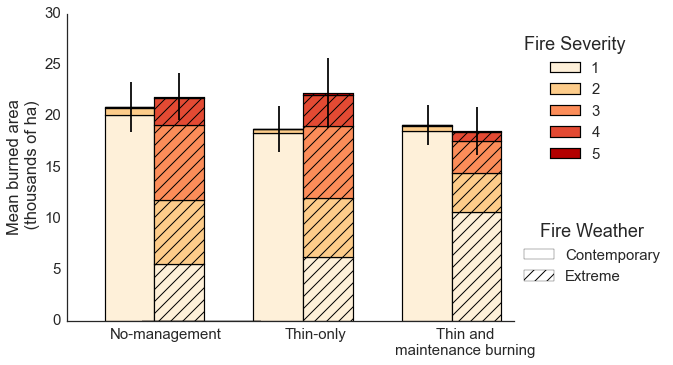

In [348]:
# ----- Gathering the means and std for the error bar plot ------ #
simSev_melt = pd.melt(simSev, id_vars = ['rep','sim'])
melted_bySev = simSev_melt.groupby(['rep','sim']).sum().reset_index()
stderrors = melted_bySev.groupby('sim').std() / (np.sqrt(50) * 1000)
means = melted_bySev.groupby('sim').mean() / 1000

df1 = simSevMean[simSevMean.FWSev == 'Contemporary']
df2 = simSevMean[simSevMean.FWSev == 'Severe']

del df1['sim']
del df1['Trtmnt']
del df1['FWSev']

del df2['sim']
del df2['Trtmnt']
del df2['FWSev']
df1 = df1 /(1000)
df2 = (df2 /1000)


df1.columns = ['1','2','3','4','5']
df2.columns = ['1','2','3','4','5']
sns.set_context('notebook', font_scale=1.5)
gg= plot_clustered_stacked([df1, df2], ["Contemporary", "Extreme"], 
                           color = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000'],
                            H="//")
sns.despine()
gg.set_xticklabels(['No-management','Thin-only', 
                    'Thin and \nmaintenance burning'], rotation = 0)
gg.set_ylabel('Mean burned area\n (thousands of ha)')
gg.set_title('')
# --- Error bars, adhoc 
historic_stderr = [2.443339,2.262693,1.948652]
severe_stderr = [2.309889,3.433463,2.348828]

historic_means = [20.87656,18.75664,19.10650]
severe_means = [21.87764,22.24698,18.50010]

plt.errorbar([-.075,.925,1.925], 
             historic_means, 
             yerr = historic_stderr, 
             linestyle = '', color = 'k')

plt.errorbar([0.25,1.25,2.25],
             severe_means, 
             yerr = severe_stderr, 
             linestyle = '', color = 'k')


plt.savefig('StackedSevsMEAN.tif',bbox_inches='tight',dpi = 150)

### Generate the mean and CV raster stacks for fire severity

In [32]:
sevMapsLowP = []
sevVarMapsLowP = []

for sim in simNamesV2:
    print dataDir + sim
    sevrasters = severityStack(dataDir + sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevMapsLowP.append(sevmap)
    sevVarMapsLowP.append(sevVarmap)


C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2


### Plot the fire severity and CV rasters

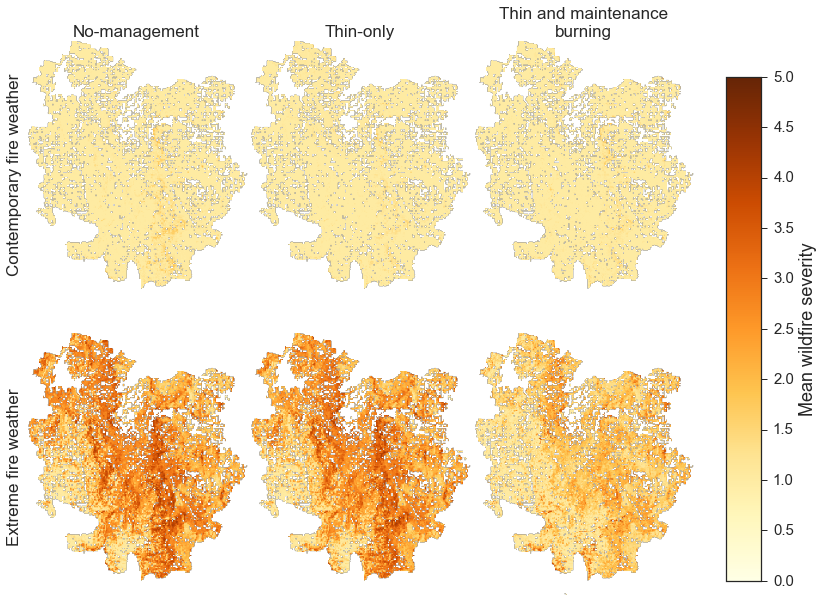

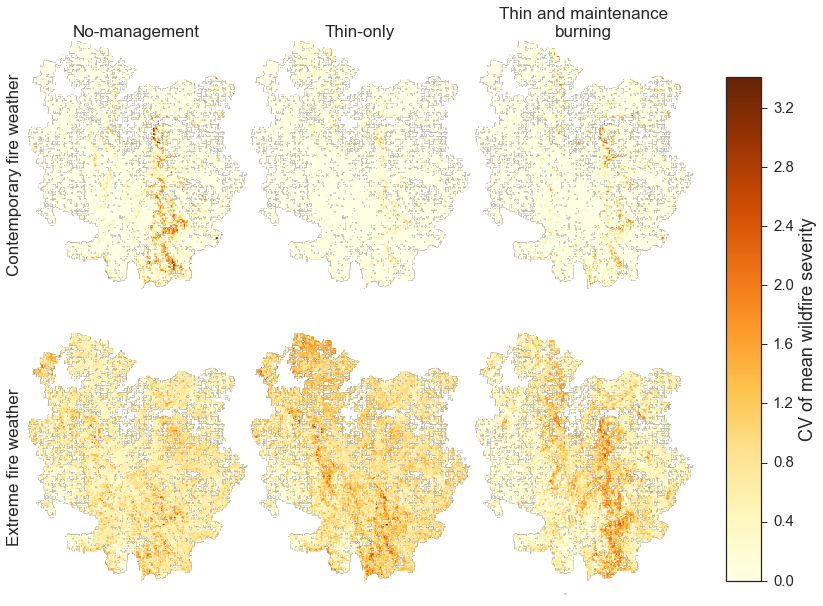

In [33]:
sns.set_context('notebook', font_scale=1.5)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevMapsLowP[0][simNamesV2[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax2.imshow(sevMapsLowP[2][simNamesV2[2]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax3.imshow(sevMapsLowP[4][simNamesV2[4]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax4.imshow(sevMapsLowP[1][simNamesV2[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax5.imshow(sevMapsLowP[3][simNamesV2[3]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax6.imshow(sevMapsLowP[5][simNamesV2[5]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('No-management', fontsize = 17)
ax2.set_title('Thin-only', fontsize = 17)
ax3.set_title('Thin and maintenance \nburning', fontsize = 17)
ax1.set_ylabel('Contemporary fire weather', fontsize = 17)
ax4.set_ylabel('Extreme fire weather', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)
plt.savefig('FireSeverity_Dinkey.tif', dpi = 300)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevVarMapsLowP[0][simNamesV2[0]], cmap = 'YlOrBr')
ax2.imshow(sevVarMapsLowP[2][simNamesV2[2]], cmap = 'YlOrBr')
ax3.imshow(sevVarMapsLowP[4][simNamesV2[4]], cmap = 'YlOrBr')
ax4.imshow(sevVarMapsLowP[1][simNamesV2[1]], cmap = 'YlOrBr')
ax5.imshow(sevVarMapsLowP[3][simNamesV2[3]], cmap = 'YlOrBr')
cbarmap = ax6.imshow(sevVarMapsLowP[5][simNamesV2[5]], cmap = 'YlOrBr')
ax1.set_title('No-management', fontsize = 17)
ax2.set_title('Thin-only', fontsize = 17)
ax3.set_title('Thin and maintenance \nburning', fontsize = 17)
ax1.set_ylabel('Contemporary fire weather', fontsize = 17)
ax4.set_ylabel('Extreme fire weather', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'CV of mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)

sns.set_style('white')
plt.savefig('FireSeverityCV_Dinkey.tif', dpi = 300)


### Quickly assess the number of ha in the severe FW simulations that had a mean severity > 3
Mean severity of 3 is pretty intense... that means on average when it burned, across 50 replicates and 100 years, the severity was 3 or greater. 

In [34]:
print 'No-management: ' + str(np.count_nonzero(sevMapsLowP[1][simNamesV2[1]].ravel() > 3))
print 'Thin-only: ' + str( np.count_nonzero(sevMapsLowP[3][simNamesV2[3]].ravel() > 3))
print 'Thin and burn: ' + str( np.count_nonzero(sevMapsLowP[5][simNamesV2[5]].ravel() > 3))

# What percent decrease is the thin and burn relative to the no management?
thinrx =  float(np.count_nonzero(sevMapsLowP[5][simNamesV2[5]].ravel() > 3.))
tonly =  float(np.count_nonzero(sevMapsLowP[3][simNamesV2[3]].ravel() > 3.))
noman = float(np.count_nonzero(sevMapsLowP[1][simNamesV2[1]].ravel() > 3.))
print 'Percent of watershed > severity 3 No Management: ' + str(noman / 45256 )
print 'Percent of watershed > severity 3 No Management: ' + str(tonly / 45256 ) 
print 'Percent of watershed > severity 3 Thin and Burn: ' + str(thinrx / 45256 ) 


No-management: 8580
Thin-only: 7613
Thin and burn: 709
Percent of watershed > severity 3 No Management: 0.189588120912
Percent of watershed > severity 3 No Management: 0.168220788404
Percent of watershed > severity 3 Thin and Burn: 0.0156664309705


### Generate the NEE and CV of NEE rasters

In [35]:
neeMapsLowP = []
neeVarMapsLowP = []

for sim in simNamesV2:
    print dataDir + sim
    neerasters = NEEStack(dataDir + sim, 100)
    neeMap, neeVarMap = NEEGen(neerasters)
    neemap = {sim : neeMap}
    neevarmap = {sim : neeVarMap}

    neeMapsLowP.append(neemap)
    neeVarMapsLowP.append(neevarmap)

neeMapsLowP[0][simNamesV2[0]][neeMapsLowP[0][simNamesV2[0]] == 0] = np.nan
neeMapsLowP[1][simNamesV2[1]][neeMapsLowP[1][simNamesV2[1]] == 0] = np.nan
neeMapsLowP[2][simNamesV2[2]][neeMapsLowP[2][simNamesV2[2]] == 0] = np.nan
neeMapsLowP[3][simNamesV2[3]][neeMapsLowP[3][simNamesV2[3]] == 0] = np.nan
neeMapsLowP[4][simNamesV2[4]][neeMapsLowP[4][simNamesV2[4]] == 0] = np.nan
neeMapsLowP[5][simNamesV2[5]][neeMapsLowP[5][simNamesV2[5]] == 0] = np.nan

Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2


#### Convert the NEE data to appropriate units, and generally clean things up.
Chunking the data up into dataframes here just makes subsetting or faceting easier if we want to look at the treatment or weather differences etc. I also change the sign convention here toward a land centric one (rather than an atmosphere centric one). 

In [36]:
len(neeMapsLowP[0][simNamesV2[0]][neeMapsLowP[0][simNamesV2[0]] > 0])
len(neeMapsLowP[0][simNamesV2[0]][neeMapsLowP[0][simNamesV2[0]] < 0])
meanAnnualNEEs1 = pd.DataFrame(dict(NEE = neeMapsLowP[0][simNamesV2[0]].ravel()*0.01 / ((50 * 100)) , 
                                  TRTMNT = 'NoAction', WEATHER = 'Contemporary'))

meanAnnualNEEs2 = pd.DataFrame(dict(NEE = neeMapsLowP[2][simNamesV2[2]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin Only', WEATHER = 'Contemporary'))

meanAnnualNEEs3 = pd.DataFrame(dict(NEE = neeMapsLowP[4][simNamesV2[4]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin + RxFire', WEATHER = 'Contemporary'))

meanAnnualNEEs4 = pd.DataFrame(dict(NEE = neeMapsLowP[1][simNamesV2[1]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'NoAction', WEATHER = 'Extreme'))

meanAnnualNEEs5 = pd.DataFrame(dict(NEE = neeMapsLowP[3][simNamesV2[3]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin Only', WEATHER = 'Extreme'))

meanAnnualNEEs6 = pd.DataFrame(dict(NEE = neeMapsLowP[5][simNamesV2[5]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin + RxFire', WEATHER = 'Extreme'))

# Concatenate our individual dataframes into a master for easy plotting etc
meanAnnualNEEs = pd.concat([meanAnnualNEEs1, meanAnnualNEEs2, meanAnnualNEEs3, meanAnnualNEEs4,
                           meanAnnualNEEs5, meanAnnualNEEs6])
meanAnnualNEEs = meanAnnualNEEs.dropna()

# Change sign convention
meanAnnualNEEs.NEE = meanAnnualNEEs.NEE * -1

#### Create a quick mean annual NEE plot
Here were trying to get a handle on what the mean annual uptake of C is for the entire landscape, over the 100 year period. Here, the error bars are derived from the actual raster values, since we are using pandas groupby mean. Not too clear on the documentation of how that works, but if I create this plot with the full length dataframe (meanAnnualNEEs), the plot is identical. Groupby just speeds up the calculation.

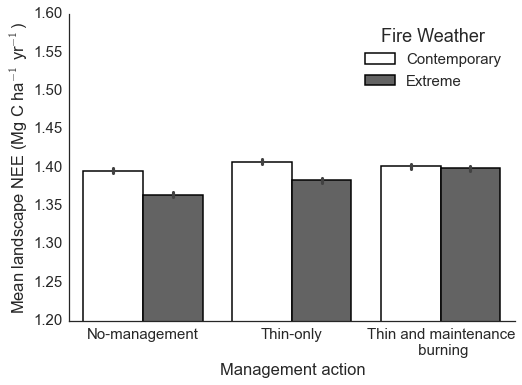

In [37]:
NEE_df = meanAnnualNEEs.groupby(['TRTMNT','WEATHER']).mean().reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'TRTMNT',y = 'NEE', hue = 'WEATHER', 
            data = meanAnnualNEEs, palette=['white','#636363'],linewidth=1.5)
sns.despine()
plt.ylim([1.2, 1.6])
plt.ylabel('Mean landscape NEE (Mg C ha$^{-1}$ yr$^{-1}$)')
plt.xlabel('Management action')
plt.legend(title = 'Fire Weather')
ax.set_xticklabels(['No-management','Thin-only','Thin and maintenance \n burning'])
sns.set_context('notebook', font_scale=1.5)
plt.savefig('meanAnnualNEE.tif', dpi = 300)


#### Frequency distributions
The differences we see above could be due to a few hugely different pixel values either due to some fluke of replication or a very localized treatment difference. Frequency distributions will help put my mind at ease -- although probabably won't look too different given the small differences in landscape NEE above.

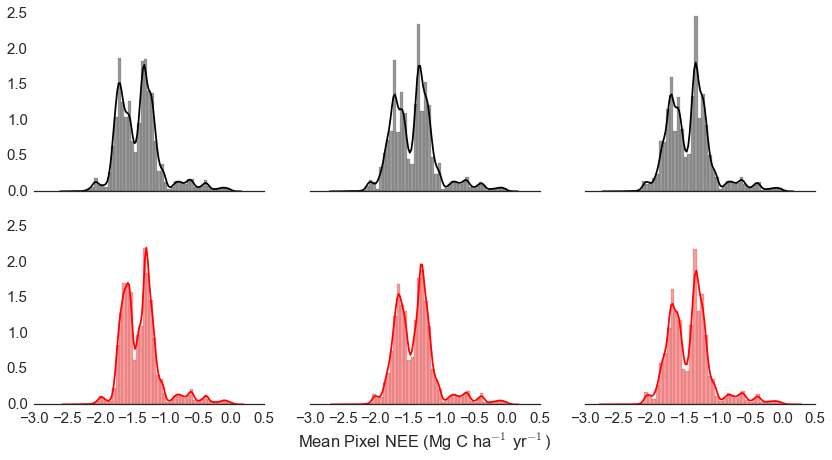

In [38]:
f, axes = plt.subplots(2, 3, figsize=(14,7), sharex=True, sharey=True)
sns.despine(left=True)

sns.distplot(meanAnnualNEEs1.NEE.dropna(), kde=True, color="k", ax=axes[0, 0])
sns.distplot(meanAnnualNEEs2.NEE.dropna(), kde=True, color="k", ax=axes[0, 1])
sns.distplot(meanAnnualNEEs3.NEE.dropna(), kde=True, color="k", ax=axes[0, 2])
sns.distplot(meanAnnualNEEs4.NEE.dropna(), kde=True, color="r", ax=axes[1, 0])
sns.distplot(meanAnnualNEEs5.NEE.dropna(), kde=True, color="r", ax=axes[1, 1])
sns.distplot(meanAnnualNEEs6.NEE.dropna(), kde=True, color="r", ax=axes[1, 2])

# Need to format all axes to remove labels
for ax in f.axes:
    ax.set_xlabel('')
axes[1, 1].set_xlabel('Mean Pixel NEE (Mg C ha$^{-1}$ yr$^{-1}$) ')
plt.savefig('MeanAnnualNEE_FrequencyDistributions.tif')

### Plot the NEE mapped data
Given the tiny landscape differences on average between management and fire weather severity, I don't expect to see any striking differences between the raw, non-differenced mapped output. So be it, lets plot it and take a look.

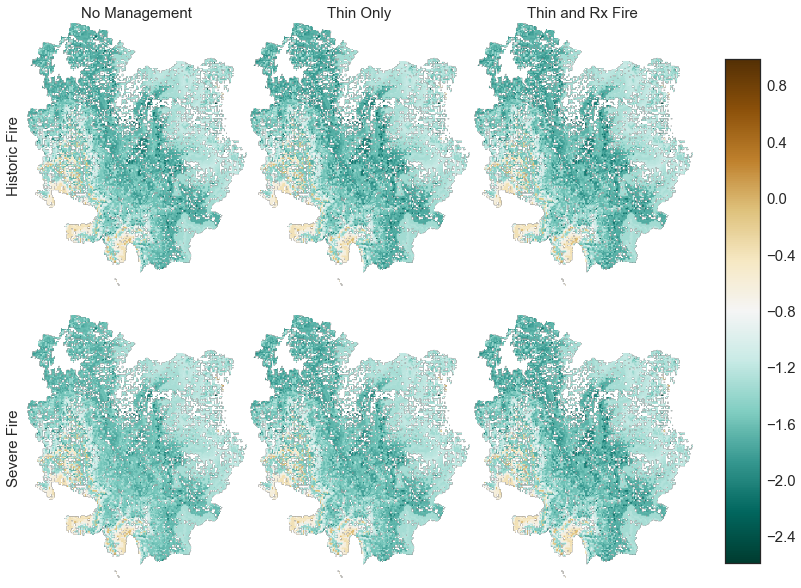

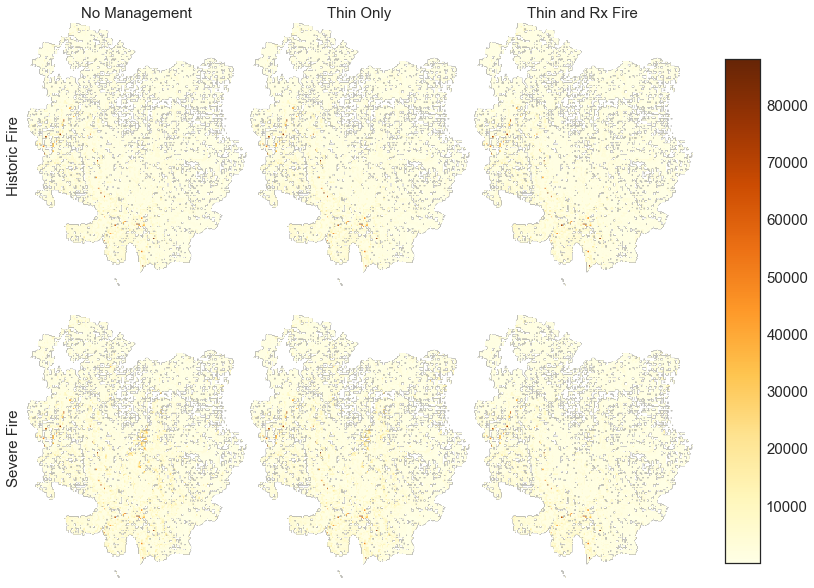

In [39]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(neeMapsLowP[0][simNamesV2[0]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax2.imshow(neeMapsLowP[2][simNamesV2[2]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax3.imshow(neeMapsLowP[4][simNamesV2[4]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax4.imshow(neeMapsLowP[1][simNamesV2[1]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax5.imshow(neeMapsLowP[3][simNamesV2[3]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
cbarmap = ax6.imshow(neeMapsLowP[5][simNamesV2[5]] / (50 * 100) * 0.01, cmap = 'BrBG_r', 
                     vmin = -2.575806, vmax = 1.00)
ax1.set_title('No Management', fontsize = 15)
ax2.set_title('Thin Only', fontsize = 15)
ax3.set_title('Thin and Rx Fire', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax4.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
plt.savefig('cumulativeNEE_Dinkey.tif')

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(neeVarMapsLowP[0][simNamesV2[0]], cmap = 'YlOrBr')
ax2.imshow(neeVarMapsLowP[2][simNamesV2[2]], cmap = 'YlOrBr')
ax3.imshow(neeVarMapsLowP[4][simNamesV2[4]], cmap = 'YlOrBr')
ax4.imshow(neeVarMapsLowP[1][simNamesV2[1]], cmap = 'YlOrBr')
ax5.imshow(neeVarMapsLowP[3][simNamesV2[3]], cmap = 'YlOrBr')
cbarmap = ax6.imshow(neeVarMapsLowP[5][simNamesV2[5]], cmap = 'YlOrBr')
ax1.set_title('No Management', fontsize = 15)
ax2.set_title('Thin Only', fontsize = 15)
ax3.set_title('Thin and Rx Fire', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax4.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
sns.set_style('white')

### Relative Difference in NEE maps
Makes sense, there's really no difference. The varuiance between replicates is also pretty low --- but there are some areas where its a bit hotter. 

For now I want to look at how much more C is taken up (and where) in the treatment scenarios vs No Management scenarios, by fire weather condition.

In [40]:
## Historic 

ThinOnly_HistoricDiff = ((neeMapsLowP[2][simNamesV2[2]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

ThinRx_HistoricDiff = ((neeMapsLowP[4][simNamesV2[4]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

ThinOnly_SevereDiff = ((neeMapsLowP[3][simNamesV2[3]] - neeMapsLowP[1][simNamesV2[1]]) /\
    neeMapsLowP[1][simNamesV2[1]]) * 100

ThinRx_SevereDiff = ((neeMapsLowP[5][simNamesV2[5]] - neeMapsLowP[1][simNamesV2[1]]) /\
    neeMapsLowP[1][simNamesV2[1]]) * 100


SEVThinOnly_HistoricDiff = ((neeMapsLowP[2][simNamesV2[2]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

SEVThinRx_HistoricDiff = ((neeMapsLowP[4][simNamesV2[4]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

SEVThinOnly_SevereDiff = ((neeMapsLowP[3][simNamesV2[3]] - neeMapsLowP[1][simNamesV2[1]]) /\
    neeMapsLowP[1][simNamesV2[1]]) * 100

SEVThinRx_SevereDiff = ((sevMapsLowP[5][simNamesV2[5]] - sevMapsLowP[1][simNamesV2[1]]) /\
    sevMapsLowP[1][simNamesV2[1]]) * 100



print np.nansum(neeMapsLowP[0][simNamesV2[0]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[2][simNamesV2[2]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[4][simNamesV2[4]].ravel()) / (50 * 100) * 0.01 / 45256

print np.nansum(neeMapsLowP[1][simNamesV2[1]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[3][simNamesV2[3]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[5][simNamesV2[5]].ravel()) / (50 * 100) * 0.01 / 45256

#ThinRx_SevereDiff[ThinRx_SevereDiff > 50] = 1
#ThinRx_SevereDiff[ThinRx_SevereDiff < -50] = -1
#ThinRx_SevereDiff[ThinRx_SevereDiff < -50] = -1


#ThinRx_SevereDiff[ThinRx_SevereDiff > 15] = 1
#ThinRx_SevereDiff[ThinRx_SevereDiff < -15] = -1

-1.39518132137
-1.40699528328
-1.40085880878
-1.36406912577
-1.38259167425
-1.39864271279


In [41]:
print np.nanmean(SEVThinOnly_HistoricDiff)
print np.nanmean(SEVThinRx_HistoricDiff)
print np.nanmean(SEVThinOnly_SevereDiff)
print np.nanmean(SEVThinRx_SevereDiff)

0.844478264203
0.479569076497
1.73289179328
-24.8807717525


In [42]:
thinrxsev = pd.DataFrame(dict(NEE_DIFF = ThinRx_SevereDiff.ravel(), TRTMNT = 'Thin + Rx Fire', 
                              WEATHER = 'Severe', SIM = 'ThinRxSevere'))
thinrxsev = thinrxsev.dropna()

thinrxhis = pd.DataFrame(dict(NEE_DIFF = ThinRx_HistoricDiff.ravel(), TRTMNT = 'Thin + Rx Fire', 
                              WEATHER = 'Historic', SIM = 'ThinRxHistoric'))
thinrxhis = thinrxhis.dropna()

thinsev = pd.DataFrame(dict(NEE_DIFF = ThinOnly_SevereDiff.ravel(), TRTMNT = 'Thin Only', 
                              WEATHER = 'Severe', SIM = 'ThinSevere'))
thinsev = thinsev.dropna()

thinhis = pd.DataFrame(dict(NEE_DIFF = ThinOnly_HistoricDiff.ravel(), TRTMNT = 'Thin Only', 
                              WEATHER = 'Historic', SIM = 'ThinHistoric'))
thinhis = thinhis.dropna()


trtmnt_diffs = pd.concat([thinrxsev,thinrxhis, thinsev, thinhis])
trtmnt_diffs.NEE_DIFF[(trtmnt_diffs.NEE_DIFF >  -5) & (trtmnt_diffs.NEE_DIFF <  5)] = np.nan

count = 0
for sim in np.unique(trtmnt_diffs.SIM):
    simsub = trtmnt_diffs[trtmnt_diffs.SIM == sim]
    if count == 0:
        capT = simsub[(simsub.NEE_DIFF < simsub.NEE_DIFF.quantile(.99)) & (simsub.NEE_DIFF > simsub.NEE_DIFF.quantile(.01))]
    else:
        cap = simsub[(simsub.NEE_DIFF < simsub.NEE_DIFF.quantile(.99)) & (simsub.NEE_DIFF > simsub.NEE_DIFF.quantile(.01))]
        capT = pd.concat([capT, cap])
    #print 'excluding data larger than ' + str(unitsub.Data.quantile(.99))
    count = count + 1

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### How many hectares experienced a 'large' difference in NEE because of treatment?
Lets look at just the pixels that experienced more than 15% change in their mean annual NEE values... either an increase or a decrease.

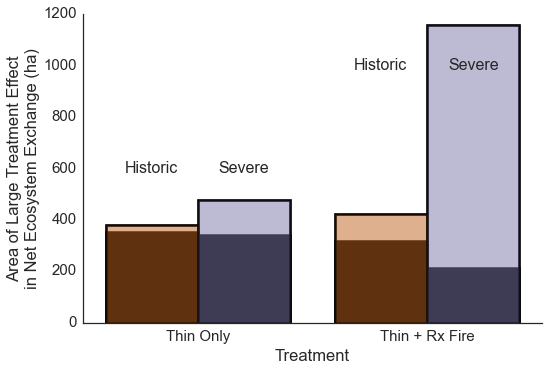

In [43]:
ha_Inc_CSink = capT[capT.NEE_DIFF > 15].groupby(['TRTMNT','WEATHER','SIM']).count().reset_index()
ha_Inc_CSink['DIR'] = 'Increase'
ha_Dec_CSink = capT[capT.NEE_DIFF < -15].groupby(['TRTMNT','WEATHER','SIM']).count().reset_index()
ha_Dec_CSink['DIR'] = 'Decrease'

CSink_ha = pd.concat([ha_Inc_CSink, ha_Dec_CSink])
legendEntries=[] 

ax = sns.barplot(x="TRTMNT", y="NEE_DIFF", hue="WEATHER", data=ha_Inc_CSink,            
                 linewidth=2.5, facecolor='white', order = ['Thin Only','Thin + Rx Fire'],
                  errcolor=".2")
legendEntries.append(ax)
ax = sns.barplot(x="TRTMNT", y="NEE_DIFF", hue="WEATHER", data=ha_Dec_CSink,        
                 linewidth=2.5, facecolor='black', order = ['Thin Only','Thin + Rx Fire'],
                  errcolor=".2")
ax = sns.barplot(x="TRTMNT", y="NEE_DIFF", hue="WEATHER", palette=['#d95f02','#7570b3'],data=ha_Inc_CSink,        
                 linewidth=2.5, alpha = 0.5, order = ['Thin Only','Thin + Rx Fire'],
                  errcolor=".2")
ax.legend('')
sns.despine()
sns.set_context('notebook',font_scale=1.5)
ax.set_ylabel('Area of Large Treatment Effect \nin Net Ecosystem Exchange (ha)')
ax.set_xlabel('Treatment')

ax.text(-.2, 600, "Historic", ha="center", va="center", size=16)
ax.text(0.2, 600, "Severe", ha="center", va="center", size=16)
ax.text(0.8, 1000, "Historic", ha="center", va="center", size=16)
ax.text(01.2, 1000, "Severe", ha="center", va="center", size=16)
plt.tight_layout()
plt.savefig('AreaChangeCSINK')

#### Not huge differences -- which we expected. Where do they fall out across the landscape?
Plotting some quick relative difference maps can help us place where these large differences are occurring on the landscape. Here, positive values indicate a percent increase in the mean (50 reps) cumulative (100 years) carbon uptake. 

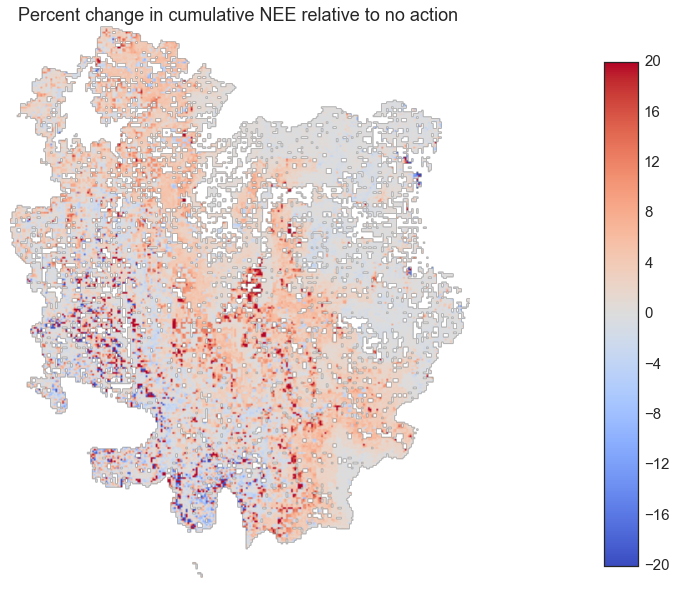

In [44]:
f, (ax1) = plt.subplots(1,1, figsize =(16,10))
plt.subplots_adjust(wspace = 0)
axs = f.axes
sns.despine(left=True, bottom=True)
ax1.set_yticklabels('')
ax1.set_xticklabels('')

cbarmap = ax1.imshow(ThinRx_SevereDiff, cmap = 'coolwarm', vmin = -20, vmax = 20)
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
ax1.set_title('Percent change in cumulative NEE relative to no action')
plt.savefig('PercentChange_NEE_Severe_ThinRx.tif')

#### We can do the same thing for fire severity
Here, negative values suggest decreases in mean fire severity relative to the No Action scenario.

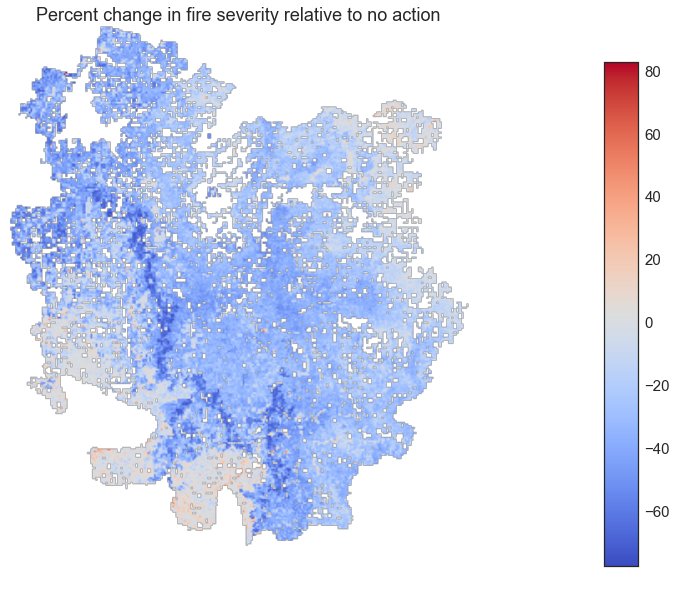

In [45]:
f, (ax1) = plt.subplots(1,1, figsize =(16,10))
plt.subplots_adjust(wspace = 0)
axs = f.axes
sns.despine(left=True, bottom=True)
ax1.set_yticklabels('')
ax1.set_xticklabels('')


cbarmap = ax1.imshow(SEVThinRx_SevereDiff, cmap = 'coolwarm')
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
ax1.set_title('Percent change in fire severity relative to no action')
plt.savefig('PercentChange_FSEV_Severe_ThinRx.tif')


### Drill into the LANDIS DFFS fire output to quantify wildfire emissions, and process stacks of thinned biomass to calculate emissions from RxFire
Normally we look at mean values per year of simulation across the 50 reps (e.g., for TEC or AGB). However, when we want to compare the end of run cumulative values for something, like in this case the cumulative emissions from wildfire, we've got to leverage another dataframe, that basically ignores the time stamps and generates a cumulative value for each column by replicate. We can then generate a distribution (boxplot, etc) of those cumulative values. 

I edited the genWeightedCentury function above to include this cumulative dataframe. Now we can integrate these data with the thin logs more easily as well.

In [46]:
import warnings # I know its bad practice ... 
warnings.filterwarnings('ignore')

totSums['SEV'] = 'NULL'
totSums.SEV[totSums.Sim == 'No Mgmt HWF'] = 'Historic'
totSums.SEV[totSums.Sim == 'Thinning HWF'] = 'Historic'
totSums.SEV[totSums.Sim == 'ThinningRx HWF'] = 'Historic'
totSums.SEV[totSums.Sim == 'No Mgmt SWF'] = 'Severe'
totSums.SEV[totSums.Sim == 'Thinning SWF'] = 'Severe'
totSums.SEV[totSums.Sim == 'ThinningRx SWF'] = 'Severe'

simsHistoric = totSums[totSums.SEV == 'Historic']
simsSevere = totSums[totSums.SEV == 'Severe']

warnings.filterwarnings('default')

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1        group2     meandiff  lower  upper  reject
----------------------------------------------------------
No Mgmt HWF   Thinning HWF  -0.2352  -0.7089 0.2385 False 
No Mgmt HWF  ThinningRx HWF -0.1014  -0.5751 0.3722 False 
Thinning HWF ThinningRx HWF  0.1337   -0.34  0.6074 False 
----------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1        group2     meandiff  lower    upper  reject
------------------------------------------------------------
No Mgmt SWF   Thinning SWF   0.7499  -11.0229 12.5226 False 
No Mgmt SWF  ThinningRx SWF -16.2141 -27.9868 -4.4414  True 
Thinning SWF ThinningRx SWF -16.964  -28.7367 -5.1913  True 
------------------------------------------------------------


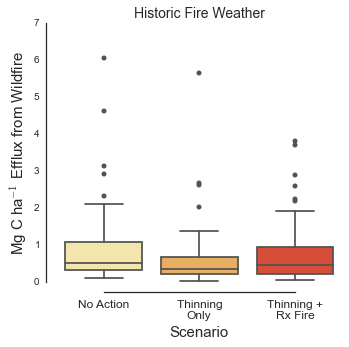

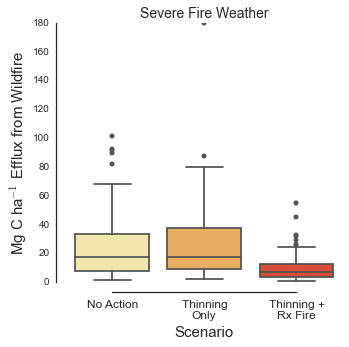

In [47]:
flierprops = dict(marker='o', markersize=5)

f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'FireCEffluxw', data = simsHistoric, 
                  palette=EcoregionFC, flierprops = flierprops)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Historic.tif')

f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'FireCEffluxw', data = simsSevere, 
                  palette=EcoregionFC, flierprops = flierprops)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Severe.tif')


print pairwise_tukeyhsd(simsHistoric.dropna()['FireCEffluxw'], simsHistoric.dropna()['Sim'])
print pairwise_tukeyhsd(simsSevere.dropna()['FireCEffluxw'], simsSevere.dropna()['Sim'])



#### Same figures as above, but with bars instead of boxes
I dont like it as much, but I should be able to more easily display the fraction of fire emissions
that are due to Rx fire.


In [48]:
2*(0.932116 / np.sqrt(50)) + .693235

0.956877217780992

In [49]:
simsHistoric.groupby('Sim').FireCEffluxw.describe()

Sim                  
No Mgmt HWF     count    50.000000
                mean      0.928410
                std       1.142581
                min       0.121416
                25%       0.318595
                50%       0.530821
                75%       1.093678
                max       6.033433
Thinning HWF    count    50.000000
                mean      0.693235
                std       0.932116
                min       0.035218
                25%       0.213572
                50%       0.354856
                75%       0.688216
                max       5.644720
ThinningRx HWF  count    50.000000
                mean      0.826963
                std       0.909490
                min       0.067666
                25%       0.218380
                50%       0.472215
                75%       0.951725
                max       3.800138
dtype: float64

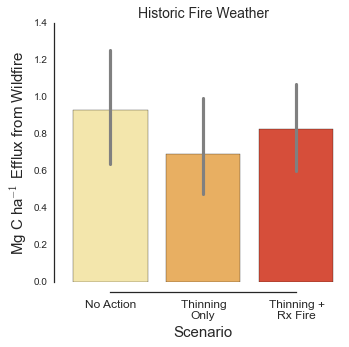

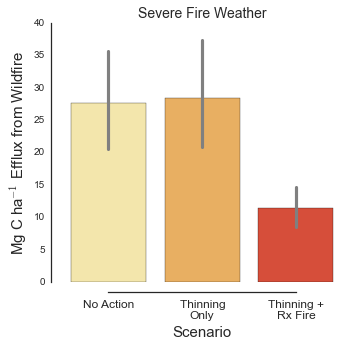

In [50]:
f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsHistoric, 
                  palette=EcoregionFC, errcolor = 'gray')
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Historic_bar.tif')

f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsSevere, 
                  palette=EcoregionFC, errcolor = 'gray')
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Severe_bar.tif')

### Histograms and Surface KDEs of mean fire severity from the DFFS fire log
These really just get at the mean severity, which is sort of normalized to some degree with fire size.. given that the larger the fire, the lower the mean will tend to be. If we want to capture the amount of torching, or describe how 'mixed' the severity of a fire is, we will have to dive fully into the fire rasters, which would take some time to loop through -- Certainly an exercise for another day ...

In [51]:
fireLoc = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
dffsLog = 'dynamic-fire-test-log.csv'

counter = 0
for simname in simNamesV2:
    num_replicates = len(next(os.walk(fireLoc + simname))[1])
    reps = np.arange(1,num_replicates+1,1)
    for rep in reps:
        wkDir_c = fireLoc + simname + '/replicate' + str(rep) + '/'
        if counter == 0:
            flogTot = pd.read_csv(wkDir_c + dffsLog)
            flogTot['SIM'] = simname
            flogTot['REP'] = rep
        else:           
            flog = pd.read_csv(wkDir_c + dffsLog)
            flog['SIM'] = simname
            flog['REP'] = rep
            flogTot = pd.concat([flogTot, flog])
        counter = counter + 1

flogTot[flogTot.TotalSitesInEvent <= 0].TotalSitesInEvent = np.nan
flogTot = flogTot.dropna()

#### Clean up and append some treatment labels to the data

In [52]:
warnings.filterwarnings('ignore')

flogTot['SEV'] = 'Null'
flogTot['TRTMNT'] = 'Null'

flogTot.SEV[flogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'Historic'
flogTot.TRTMNT[flogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'No Action'

flogTot.SEV[flogTot.SIM == 'ThinHistoric_FV2'] = 'Historic'
flogTot.TRTMNT[flogTot.SIM == 'ThinHistoric_FV2'] = 'Thinning Only'

flogTot.SEV[flogTot.SIM == 'ThinRxHistoric_FV2'] = 'Historic'
flogTot.TRTMNT[flogTot.SIM == 'ThinRxHistoric_FV2'] = 'Thinning + Rx Fire'

flogTot.SEV[flogTot.SIM == 'NoMgmtSevereFireLowP'] = 'Severe'
flogTot.TRTMNT[flogTot.SIM == 'NoMgmtSevereFireLowP'] = 'No Action'

flogTot.SEV[flogTot.SIM == 'ThinSevere_FV2'] = 'Severe'
flogTot.TRTMNT[flogTot.SIM == 'ThinSevere_FV2'] = 'Thinning Only'

flogTot.SEV[flogTot.SIM == 'ThinRxSevere_FV2'] = 'Severe'
flogTot.TRTMNT[flogTot.SIM == 'ThinRxSevere_FV2'] = 'Thinning + Rx Fire'


flogTot[flogTot.TotalSitesInEvent == 0] = np.nan

warnings.filterwarnings('default')

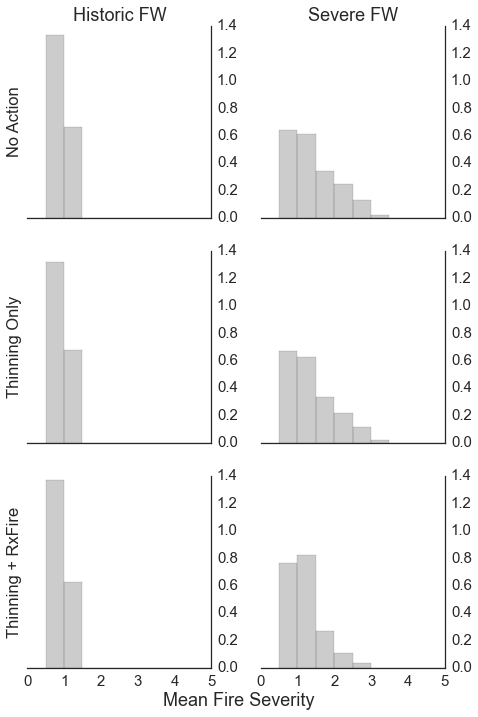

In [53]:
# Set up the  figure
sns.set_context('notebook', font_scale=1.5)
f, axes = plt.subplots(3, 2, figsize=(7, 10), sharex=True, sharey = True)
subplots_adjust(hspace = 0.20, wspace = 0.4)
axs = f.axes
idx = 0

for sim in simNamesV2:
    ax = axs[idx]
    toplot = flogTot[flogTot.SIM == sim]
    sns.distplot(toplot.MeanSeverity, kde=False, color="gray", 
                 bins=np.linspace(0,5,11),norm_hist = True, ax=ax)
    ax.set_xlabel('')
    # Setup the facet and axes labels
    if idx == 0:
        ax.set_title('Historic FW')
        ax.set_ylabel('No Action')
        
    if idx == 1:
        ax.set_title('Severe FW')

    if idx == 2:
        ax.set_ylabel('Thinning Only')
        
    if idx == 4:
        ax.set_ylabel('Thinning + RxFire')
        
    idx = idx + 1

# Create joint X label
f.text(0.5, 0.01, 'Mean Fire Severity', ha='center', va='center')

#plt.tight_layout()
sns.set_style('ticks')
sns.despine(left = True, right = False)
plt.tight_layout()
plt.savefig('FireSize_Dist.tif')

#### We need a similar figure, but to capture the fire size distributions from our simulations
Same approach, since we have fire size data in the fire logs.

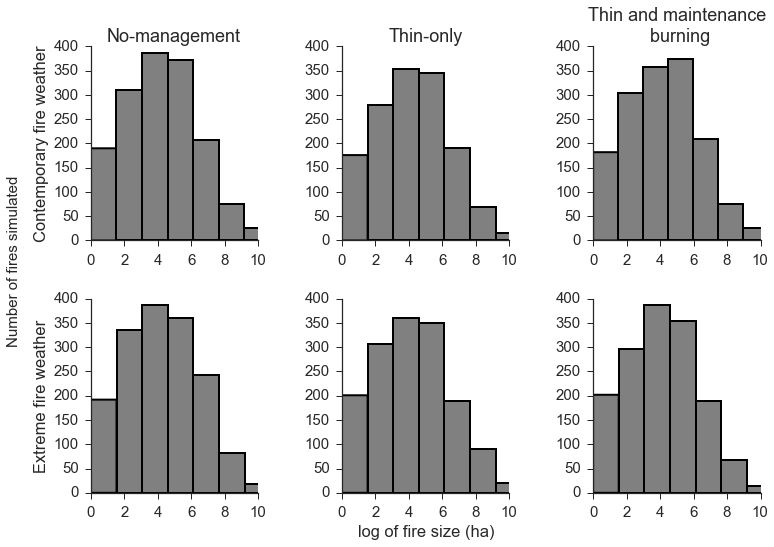

In [54]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(12,8))
axs = f.axes
idx = 0
plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
for sim in simNamesV2:
    if idx == 0:
        ax = axs[idx]
        ax.set_ylabel('Contemporary fire weather')
        ax.set_title('No-management')
    elif idx == 1:
        ax = axs[3]
        ax.set_ylabel('Extreme fire weather')
        ax.set_title('')
    elif idx == 2:
        ax = axs[1]
        ax.set_title('Thin-only')
    elif idx == 3:
        ax = axs[4]
    elif idx == 4:
        ax = axs[2]
        ax.set_title('Thin and maintenance\n burning')

    else:
        ax = axs[5]

    simsub = flogTot[flogTot.SIM == sim]
    simsreps = simsub.groupby('REP').mean()
    sns.distplot(np.log(simsub.TotalSitesInEvent), 
                 hist = True, kde = False, 
                 hist_kws={"linewidth": 2,
                             "alpha": 1, "color": "gray"},
                 bins = 7, ax = ax)

    ax.set_xlim([0,10])
    #ax.set_ylim([0,20])
    numFires = simsreps.count()
    if idx == 3:
        ax.set_xlabel('log of fire size (ha)')
    else:
        ax.set_xlabel('')
    #ax.set_xticks([4,5,6,7,8])
    idx = idx + 1
sns.despine()
sns.set_context('notebook', font_scale=1.4)
sns.set_style('white')
plt.text(-35,630,'Number of fires simulated', rotation = 90, size = 15)
plt.savefig('FireSizeHIST.tiff')


C:\Anaconda\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


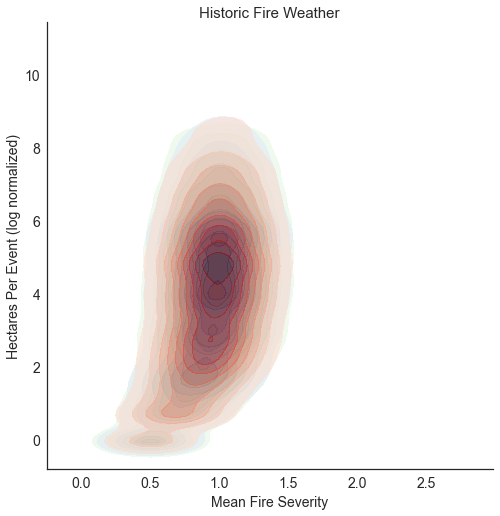

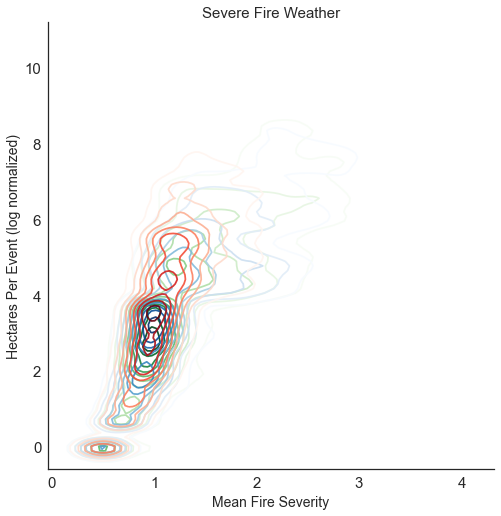

In [55]:
# Set up the figure -- Basically slapping three KDEs (one per sim) 
# on each fig panel, with each panel representing fire weather severity
f, ax = plt.subplots(figsize=(8, 8))

#ax.set_aspect("equal")
thismap = ['Greens','Blues','Reds']

idx = 0
for SIMNAME in ['NoMgmtHistoricFireLowP','ThinHistoric_FV2', 'ThinRxHistoric_FV2']:
    toPlot = flogTot[flogTot.SIM == SIMNAME]
    ax = sns.kdeplot(toPlot.MeanSeverity, np.log(toPlot.TotalSitesInEvent),
                     cmap=thismap[idx], shade=True, shade_lowest=False,bw = .25, alpha = 0.5)
    idx = idx + 1
ax.set_title('Historic Fire Weather', fontsize = 15)
ax.set_xlabel('Mean Fire Severity', fontsize = 14)
ax.set_ylabel('Hectares Per Event (log normalized)', fontsize = 14)
sns.set_context('notebook', font_scale=1.5)
sns.despine()
plt.savefig('FireSize_Hist_KDE.tif')

f, ax = plt.subplots(figsize=(8, 8))
idx = 0   
for SIMNAME in ['NoMgmtSevereFireLowP','ThinSevere_FV2', 'ThinRxSevere_FV2']:
    toPlot = flogTot[flogTot.SIM == SIMNAME]
    ax = sns.kdeplot(toPlot.MeanSeverity, np.log(toPlot.TotalSitesInEvent),
                     cmap=thismap[idx], shade=False, shade_lowest=False, bw = .18, alpha = .9)
    idx = idx + 1
ax.set_title('Severe Fire Weather', fontsize = 15)
ax.set_xlabel('Mean Fire Severity', fontsize = 14)
ax.set_ylabel('Hectares Per Event (log normalized)', fontsize = 14)
sns.set_context('notebook', font_scale=1.5)
sns.despine()
plt.savefig('FireSize_Sev_KDE.tif')


### How much biomass was removed during mechanical thinning, and volatalized during Rx Fire? 
To answer those questions we need to drill into the thin logs. Lets start by making a data frame that contains summary info for each weather and treatment permutation, maybe wrap it into a function for furture LANDIS work, since thats baller.

In [56]:
### ***** This is a time consuming step ***** ###

thinLoc = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
thinLog = 'log.csv'

# We only want (can) look at the thin logs for the managed scenarios
simsManaged = ['ThinHistoric_FV2', 'ThinSevere_FV2',
            'ThinRxHistoric_FV2','ThinRxSevere_FV2']

counter = 0
for simname in simsManaged:
    num_replicates = len(next(os.walk(fireLoc + simname))[1])
    reps = np.arange(1,num_replicates+1,1)
    for rep in reps:
        wkDir_c = thinLoc + simname + '/replicate' + str(rep) + '/Thin/'
        if counter == 0:
            tlogTot = pd.read_csv(wkDir_c + thinLog)
            tlogTot['SIM'] = simname
            tlogTot['REP'] = rep
        else:           
            tlog = pd.read_csv(wkDir_c + thinLog)
            tlog['SIM'] = simname
            tlog['REP'] = rep
            tlogTot = pd.concat([tlogTot, tlog])
        counter = counter + 1



In [57]:
warnings.filterwarnings('ignore')

tlogTot['SEV'] = 'Null'
tlogTot['TRTMNT'] = 'Null'

tlogTot.SEV[tlogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'Historic'
tlogTot.TRTMNT[tlogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'No Action'

tlogTot.SEV[tlogTot.SIM == 'ThinHistoric_FV2'] = 'Historic'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinHistoric_FV2'] = 'Thinning Only'

tlogTot.SEV[tlogTot.SIM == 'ThinRxHistoric_FV2'] = 'Historic'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinRxHistoric_FV2'] = 'Thinning + Rx Fire'

tlogTot.SEV[tlogTot.SIM == 'NoMgmtSevereFireLowP'] = 'Severe'
tlogTot.TRTMNT[tlogTot.SIM == 'NoMgmtSevereFireLowP'] = 'No Action'

tlogTot.SEV[tlogTot.SIM == 'ThinSevere_FV2'] = 'Severe'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinSevere_FV2'] = 'Thinning Only'

tlogTot.SEV[tlogTot.SIM == 'ThinRxSevere_FV2'] = 'Severe'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinRxSevere_FV2'] = 'Thinning + Rx Fire'


warnings.filterwarnings('default')

#### Now that we have the thin log data
stored as one giant dataframe, we need to take sums by treatment/weather across reps. The goal here will be to calculate the mean of the 50 sums (reps) within treatments, so we can report a mean and variance of the biomass removed (or volatized) per treatment/weather combo

In [58]:
groupedTlog = tlogTot.groupby(['SIM','Prescription','SEV','TRTMNT','REP']).sum()
thinByRep = groupedTlog.reset_index()

thinMean = thinByRep.groupby(['SIM','Prescription','SEV','TRTMNT']).mean().reset_index()
thinStd = thinByRep.groupby(['SIM','Prescription','SEV','TRTMNT']).std().reset_index()

#thinSumMGMT = tlogTot.groupby(['SIM','ManagementArea','Prescription','SEV','TRTMNT','REP']).sum().reset_index()
thinMeanMGMT = tlogTot.groupby(['SIM','ManagementArea','Prescription','SEV','TRTMNT','REP']).mean().reset_index()

# Normalize the Biomass Removed by the total area of the simulation (active grid cells), 
# and turn AGB into C. This will make our management C numbers mesh well with the Wildfire C emissions
# from the century output
thinMean['activeArea'] = 45256
thinByRep['activeArea'] = 45256

thinMean['AreaWeightedC_Reduc'] = (thinMean.MgBiomassRemoved / thinMean['activeArea'])*.5
thinByRep['AreaWeightedC_Reduc'] = (thinByRep.MgBiomassRemoved / thinByRep['activeArea'])*.5


KeyboardInterrupt: 

#### Finally we can create some summary figures 
that look at how biomass was removed across the simulations. I need to calculate the area of each management unit, in order to calculate the per hectare biomass removed, per management unit.

In [ ]:
# First lets just import the management unit raster and count the number of cells (ha) in each mgmt unit.
# Read in the raster
mgmtUnit = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/MgmtRedux.tif'
src_ds = gdal.Open( mgmtUnit )
mgmtmap = src_ds.ReadAsArray()
mgmtmap = mgmtmap.astype('float')
mgmtmap[mgmtmap == 0] = np.nan
masked_bio = np.ma.array (mgmtmap, mask=(np.isnan(mgmtmap)))  

# Create the figure and show the image
f, (ax) = plt.subplots(1,1, figsize =(7,7))
axmap = ax.imshow(mgmtmap, cmap = 'gray')

# Axis label formatting, and seaborn despining
ax.set_yticklabels('')
ax.set_xticklabels('')
sns.despine(left=True, bottom=True)
sns.set_style('white')

# Create a dummy variable, tehn fill it with the respective areas of each management unit
thinMeanMGMT['mgmtArea'] = 0
for mgmt in [1,2,3,4]:
    thinMeanMGMT.mgmtArea[thinMeanMGMT.ManagementArea == mgmt] = len(mgmtmap[mgmtmap == mgmt])

# Now calculate the respective area weighted C reduction
thinMeanMGMT['AreaWeightedC_Reduc'] = (thinMeanMGMT.MgBiomassRemoved / thinMeanMGMT['mgmtArea'])*.5


In [ ]:
ForArea
#divArea
#(sum(divArea))
sum(ForArea)

In [ ]:
ForArea = thinMeanMGMT.mgmtArea.unique()
HFRI = [20,25,15,40]
divArea = ForArea / HFRI
(sum(divArea) * 10.) / sum(ForArea)

In [ ]:
g = sns.factorplot(x="Prescription", y='AreaWeightedC_Reduc',
                   hue = 'TRTMNT', data=thinByRep,
                   size=6, kind="bar", palette="muted", legend = False)
g.set_xticklabels(['Mechanical \nThin','Mcon-Fir','Mcon-Pine','PPine','Red Fir'], rotation = 30)

RxFireProp = dict(boxstyle="round, pad =0.8", fc="w", ec="black", alpha=0.7)
plt.text(2.7, 4, "Rx Fire", ha="center", va="center", size=20,
        bbox=RxFireProp)

g.set_xlabels('Management Prescription')
g.set_ylabels('Cumulative C Removed (Mg ha$^{-1}$)')
g.set_titles('End of Simulation C Reductions')
plt.legend(title = 'Management Options')
sns.set_context('notebook', font_scale=1.5)
plt.tight_layout()

sns.set_context('notebook', font_scale=1.5)
plt.savefig('CarbonRemoved_Mgmt.tif')

g = sns.factorplot(x="SIM", y='AreaWeightedC_Reduc',data=thinMeanMGMT,
                   size=6, kind="bar", palette="muted", legend = False)

g.set_xlabels('Management Prescription')
g.set_ylabels('Cumulative C Removed (Mg ha$^{-1}$)')
g.set_titles('End of Simulation C Reductions')
plt.legend(title = 'Management Options')
sns.set_context('notebook', font_scale=1.5)
plt.tight_layout()

sns.set_context('notebook', font_scale=1.5)
plt.savefig('CarbonRemoved_MgmtSep.tif')



In [ ]:
100/9.

#### This is turning into a pain in the ass, and probably a waste of time
Im saying screw it and moving toward reading in the rasters as a stack, then doing cumulative sums by ecoregion. I added the apropriate thin stacking functions above, where the burn severity and NEE raster stacking functions live. Called in the same way, I added a timestamp checker to create three total rasters, one with sumulative biomass removed from time 1 - 100, one for the first 10 years, and one for the last 90. I'll still have to deal with the Red Fir RxFire treatments starting at year 1, but plan to handle that with some raster math and the management unit raster above.


In [ ]:
dataDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
thinMapsLowP = []
thinVarMapsLowP = []
thinCountMapsLowP = []

thinOnlyMapsLowP = []
thinOnlyVarMapsLowP = []
thinOnlyCountMapsLowP = []

thinRxMapsLowP = []
thinRxVarMapsLowP = []
thinRxCountMapsLowP = []

mgmtSims = ['ThinHistoric_FV2', 'ThinSevere_FV2',
            'ThinRxHistoric_FV2','ThinRxSevere_FV2']

for sim in mgmtSims:
    print dataDir + sim
    thinrasters,thinrastersTO,thinrastersRX = THINStack(dataDir + sim, 100)
    thinCOUNT, thinSUM, thinVAR = THINGen(thinrasters)
    thinmap = {sim : thinSUM}
    thinvarmap = {sim : thinVAR}
    thincountmap = {sim : thinCOUNT}
    
    thinOnlyCOUNT, thinOnlySUM, thinOnlyVAR = THINGen(thinrastersTO)
    thinOmap = {sim : thinOnlySUM}
    thinOvarmap = {sim : thinOnlyVAR}
    thinOcountmap = {sim : thinOnlyCOUNT}

    thinRxCOUNT, thinRxSUM, thinRxVAR = THINGen(thinrastersRX)
    thinRxmap = {sim : thinRxSUM}
    thinRxvarmap = {sim : thinRxVAR}
    thinRxcountmap = {sim : thinRxCOUNT}

    # list of dicts for all biomass removal
    thinMapsLowP.append(thinmap)
    thinVarMapsLowP.append(thinvarmap)
    thinCountMapsLowP.append(thincountmap)
 
    # list of dicts for all Thin Only removal
    thinOnlyMapsLowP.append(thinOmap)
    thinOnlyVarMapsLowP.append(thinOvarmap)
    thinOnlyCountMapsLowP.append(thinOcountmap)
    
    # list of dicts for MOST Rx Fire removal
    thinRxMapsLowP.append(thinRxmap)
    thinRxVarMapsLowP.append(thinRxvarmap)
    thinRxCountMapsLowP.append(thinRxcountmap)



#### Quick look at the biomass removed spatially

In [ ]:
thinOnlyMapsLowP[0][mgmtSims[0]][thinOnlyMapsLowP[0][mgmtSims[0]] == 0] = np.nan
thinOnlyMapsLowP[1][mgmtSims[1]][thinOnlyMapsLowP[1][mgmtSims[1]] == 0] = np.nan
thinOnlyMapsLowP[2][mgmtSims[2]][thinOnlyMapsLowP[2][mgmtSims[2]] == 0] = np.nan
thinOnlyMapsLowP[3][mgmtSims[3]][thinOnlyMapsLowP[3][mgmtSims[3]] == 0] = np.nan

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize =(10,10))
plt.subplots_adjust(wspace = 0, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(thinOnlyMapsLowP[0][mgmtSims[0]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 100)
ax2.imshow(thinOnlyMapsLowP[2][mgmtSims[2]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 100)
ax3.imshow(thinOnlyMapsLowP[1][mgmtSims[1]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 100)
cbarmap = ax4.imshow(thinOnlyMapsLowP[3][mgmtSims[3]] * ((0.01) / 50), cmap = 'YlOrBr')
ax1.set_title('Thin Only', fontsize = 15)
ax2.set_title('Thin and Burn', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax3.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.9, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)


#### Quantify the biomass removed per unit area within each managment unit
We want these data by forest type (management unit), and by prescription. Thinning takes place over the first 10 years in our simulations, really over the firs 5, so we sum up within each management unit the thin maps for the first 10, and last 90, to get values for thin only and rx fire only respectively. Then we have to sum up the entire stack (year 1 - 100) to get rx fire in the red fir management unit, since we didn't thin that forest type and rx fire began at year 1.

In [ ]:
# mean cumulative C removalper hectare over the 100 years. First 10 from thinning
print np.nansum(thinOnlyMapsLowP[0][mgmtSims[0]][mgmtmap == 1]) * ((0.01) / 50) / mgmtmap[mgmtmap==1].size
print np.nansum(thinOnlyMapsLowP[0][mgmtSims[0]][mgmtmap == 2]) * ((0.01) / 50) / mgmtmap[mgmtmap==2].size
print np.nansum(thinOnlyMapsLowP[0][mgmtSims[0]][mgmtmap == 3]) * ((0.01) / 50) / mgmtmap[mgmtmap==3].size

# Next 90 from Rx Fire
print np.nansum(thinRxMapsLowP[2][mgmtSims[2]][mgmtmap == 1]) * ((0.01) / 50) / mgmtmap[mgmtmap==1].size
print np.nansum(thinRxMapsLowP[2][mgmtSims[2]][mgmtmap == 2]) * ((0.01) / 50) / mgmtmap[mgmtmap==2].size
print np.nansum(thinRxMapsLowP[2][mgmtSims[2]][mgmtmap == 3]) * ((0.01) / 50) / mgmtmap[mgmtmap==3].size

# Whole 100 years of Rx Fire in Red Fir
print np.nansum(thinMapsLowP[2][mgmtSims[2]][mgmtmap == 4]) * ((0.01) / 50) / mgmtmap[mgmtmap==4].size


#### Wash rince and repeat to assess the standard deviation

In [ ]:
# mean cumulative C removalper hectare over the 100 years. First 10 from thinning
print np.sqrt(np.nansum(thinOnlyVarMapsLowP[0][mgmtSims[0]][mgmtmap == 1]) * ((0.01) / 50) / mgmtmap[mgmtmap==1].size)
print np.sqrt(np.nansum(thinOnlyVarMapsLowP[0][mgmtSims[0]][mgmtmap == 2]) * ((0.01) / 50) / mgmtmap[mgmtmap==2].size)
print np.sqrt(np.nansum(thinOnlyVarMapsLowP[0][mgmtSims[0]][mgmtmap == 3]) * ((0.01) / 50) / mgmtmap[mgmtmap==3].size)

# Next 90 from Rx Fire
print np.sqrt(np.nansum(thinRxVarMapsLowP[2][mgmtSims[2]][mgmtmap == 1]) * ((0.01) / 50) / mgmtmap[mgmtmap==1].size)
print np.sqrt(np.nansum(thinRxVarMapsLowP[2][mgmtSims[2]][mgmtmap == 2]) * ((0.01) / 50) / mgmtmap[mgmtmap==2].size)
print np.sqrt(np.nansum(thinRxVarMapsLowP[2][mgmtSims[2]][mgmtmap == 3]) * ((0.01) / 50) / mgmtmap[mgmtmap==3].size)

# Whole 100 years of Rx Fire in Red Fir
print np.sqrt(np.nansum(thinVarMapsLowP[2][mgmtSims[2]][mgmtmap == 4]) * ((0.01) / 50) / mgmtmap[mgmtmap==4].size)


#### Finally, a quick calculation of the cumulative Mg C removed by Rx Fire
because these numbers probably don't vary much from run to run, I 
could just stop there... but the paranoia started to set in. Lets also 
take the data grouped by replicate, and make sure.

In [ ]:
warnings.filterwarnings('ignore')

# These are basically the mean emissions across replicates
RxEmissionsH = thinMean[(thinMean.Prescription != 'ThinOnly') & \
                        (thinMean.SEV == 'Historic')].AreaWeightedC_Reduc.sum()
RxEmissionsS = thinMean[(thinMean.Prescription != 'ThinOnly') & \
                        (thinMean.SEV == 'Severe')].AreaWeightedC_Reduc.sum()
print RxEmissionsH
print RxEmissionsS

allRxEmissionsH = thinByRep[(thinByRep.Prescription != 'ThinOnly') & \
                        (thinByRep.SEV == 'Historic')].groupby('REP').sum().reset_index()

allRxEmissionsS = thinByRep[(thinByRep.Prescription != 'ThinOnly') & \
                        (thinByRep.SEV == 'Severe')].groupby('REP').sum().reset_index()

# Now we have to add these values to the FireEfflux(adjusted) values for the Thin + Rx Fire simulations
simsHistoric['RxAdjustedEmissions'] = simsHistoric.FireCEffluxw 
simsSevere['RxAdjustedEmissions'] = simsSevere.FireCEffluxw 

simsHistoric['propOfWF'] = 0 
simsSevere['propOfWF'] = 0

simsHistoric.RxAdjustedEmissions[simsHistoric.Sim == 'ThinningRx HWF'] = \
    simsHistoric.RxAdjustedEmissions[simsHistoric.Sim == 'ThinningRx HWF'] + allRxEmissionsH.AreaWeightedC_Reduc
simsSevere.RxAdjustedEmissions[simsSevere.Sim == 'ThinningRx SWF'] = \
    simsSevere.RxAdjustedEmissions[simsSevere.Sim == 'ThinningRx SWF'] + allRxEmissionsS.AreaWeightedC_Reduc

# What is the proportion of the fire emissions of C that is due to management?
simsHistoric.propOfWF[simsHistoric.Sim == 'ThinningRx HWF'] = \
    allRxEmissionsH.AreaWeightedC_Reduc / simsHistoric.RxAdjustedEmissions[simsHistoric.Sim == 'ThinningRx HWF']
simsSevere.propOfWF[simsSevere.Sim == 'ThinningRx SWF'] = \
    allRxEmissionsS.AreaWeightedC_Reduc / simsSevere.RxAdjustedEmissions[simsSevere.Sim == 'ThinningRx SWF']
    
simsHistoric['RxOnly'] = 0
simsSevere['RxOnly'] = 0 
simsHistoric.RxOnly[simsHistoric.Sim == 'ThinningRx HWF'] = allRxEmissionsH.AreaWeightedC_Reduc
simsSevere.RxOnly[simsSevere.Sim == 'ThinningRx SWF'] = allRxEmissionsS.AreaWeightedC_Reduc

warnings.filterwarnings('default')

#### Now revisit the bar plots from before, but adding in the above Rx Fire C emissions

In [ ]:
f, ax = plt.subplots(figsize = (5,5))
fig = sns.barplot(x = 'Sim', y = 'RxAdjustedEmissions', data = simsHistoric, 
                  color='r', errcolor = 'gray', alpha = 0.5, capsize = 0.05)
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsHistoric, 
                  color='gray', errcolor = 'k', capsize = 0.05)

sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Cumulative fire efflux (Mg C ha$^{-1}$)', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No-management', 'Thin-only','Thin and maintenance \nburning'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Contemporary Fire Weather', fontsize = 14)
plt.tight_layout()
ax.text(0.05, 1, 'A', transform=ax.transAxes, fontsize=17)

plt.savefig('Wildfire_Rx_Emissions_Historic_bar.tif', dpi = 300)

f, ax = plt.subplots(figsize = (5,5))
fig = sns.barplot(x = 'Sim', y = 'RxAdjustedEmissions', data = simsSevere, 
                  color='r', errcolor = 'gray', alpha = 0.5, capsize = 0.05)
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsSevere, 
                  color='gray', errcolor = 'k', capsize = 0.05)

sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Cumulative fire efflux (Mg C ha$^{-1}$)', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No-management', 'Thin-only','Thin and maintenance \nburning'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Extreme Fire Weather', fontsize = 14)
plt.tight_layout()
ax.text(0.05, 1, 'B', transform=ax.transAxes, fontsize=17)

plt.savefig('Wildfire_Rx_Emissions_Severe_bar.tif', dpi = 300)
print pairwise_tukeyhsd(simsHistoric.dropna()['RxAdjustedEmissions'], simsHistoric.dropna()['Sim'])
print pairwise_tukeyhsd(simsSevere.dropna()['RxAdjustedEmissions'], simsSevere.dropna()['Sim'])


#### I want to calculate the mean area burned (Rx Fire) per timestep
To do this, we dive into the thin logs, and look at only the Rx Fire prescription. We decided to couch these numbers in the paper as the mean area burned per prescribed fire entry, and also record the return interval. This way it will be apparent to the readership that while the PPINE forest type on average burned fewer hectares per entry, fire was more common in that system.

In [ ]:
timeThinMean = tlogTot.groupby(['SIM', 'Prescription','Time', 'REP']).sum().reset_index()
timeThinMean = timeThinMean[timeThinMean.SIM == 'ThinRxHistoric_FV2']
for prescrip in np.unique(timeThinMean.Prescription):
    print '---' + prescrip + '--- Mean'
    trtmnt_type = timeThinMean[timeThinMean.Prescription == prescrip]
    print trtmnt_type.groupby('Time').mean().DamagedSites.mean()
    
for prescrip in np.unique(timeThinMean.Prescription):
    print '---' + prescrip + '--- Standard Deviation'
    trtmnt_type = timeThinMean[timeThinMean.Prescription == prescrip]
    print np.sqrt(trtmnt_type.groupby('Time').mean().DamagedSites.var())

#### What is the chance of fire across the landscape?
This is a difficult question.. are we talking about the chance of fire at a given point? across the entire watershed? My inclination would be that probability of fire occurring in some area is going to go up with the size of the area. We could add up all the fires for a given simulation, and divide by the number of years and reps (5,000).

In [ ]:
len(flogTot[flogTot.SIM == 'ThinRxHistoric_FV2']) / (50. * 100)

#### Thats not very low.. 
Is that a bad thing? This tells me that every year, there is a 1 in 3 chance that there will be a fire, Somewhere in the watershed. It does not speak to the severity or extent of the fire.. just that its likely to happen one in three times. What if we know something else about the system... for instance, that within that area there are 36 attempts made per year to start a fire. 

In [ ]:
len(flogTot[flogTot.SIM == 'ThinRxHistoric_FV2']) / (50. * 100 * 36)
#flogTot.REP

#### Now were looking at a 1 in 125 chance of fire
0.008 as a fraction is 1/125 ... much lower, and actually sort of on par with our fuel type ingnition probabilities in the Dynamic Fire and Fuel System within LANDIS-II. Again, I don't really know which is the correct way to go. Something that might fit the discussion better may be the probability of Severe fire (or at least moderate). Lets repeat this but look only at fires with a mean severity > 1... that way we know fire weather will be driving the numbers UP for severe and DOWN for historic.

In [ ]:
print '----Historic FW----'
severeFires = flogTot[flogTot.MeanSeverity >= 1]
print 'Prob per year: ' + \
    str(len(severeFires[severeFires.SIM == 'NoMgmtHistoricFireLowP']) / (50. * 100))

print 'Prob normed by num ignitions ' + \
    str(len(severeFires[severeFires.SIM == 'NoMgmtHistoricFireLowP']) / (50. * 100 * 36))

print '----Severe FW----'
severeFires = flogTot[flogTot.MeanSeverity >= 1]
print 'Prob per year: ' + \
    str(len(severeFires[severeFires.SIM == 'NoMgmtSevereFireLowP']) / (50. * 100))


severeFires = flogTot[flogTot.MeanSeverity >= 1]
print 'Prob normed by num ignitions ' + \
    str(len(severeFires[severeFires.SIM == 'NoMgmtSevereFireLowP']) / (50. * 100 * 36))


#### So were looking at 1 in 10 to 1 in 5 for historic and severe respectively
or i in 500 and 3 in 500... depending on how we want to calculate the stat. These are mean severity >=1 .. which is super low. As soon as we start looking at severities > 1.3, the Historic FW scenarios counts drop down to NIL (makes sense).